# Imports

In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import pandas as pd

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

import re
import anndata as ad

import scvelo as scv
from scipy.sparse import csr_matrix

import scipy.io as sio

/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

## The following steps only need to be run once

# Load and Merge Data

In [2]:
os.listdir('../results/clean_adata/')

['.ipynb_checkpoints',
 '14dpa_combineddenoised.h5',
 '14dpa_combineddenoised.log',
 '14dpa_combineddenoised.pdf',
 '14dpa_combineddenoised_cell_barcodes.csv',
 '14dpa_combineddenoised_filtered.h5',
 '14dpa_combineddenoised_metrics.csv',
 '14dpa_combineddenoised_posterior.h5',
 '22dpa_combineddenoised.h5',
 '22dpa_combineddenoised.log',
 '22dpa_combineddenoised.pdf',
 '22dpa_combineddenoised_cell_barcodes.csv',
 '22dpa_combineddenoised_filtered.h5',
 '22dpa_combineddenoised_metrics.csv',
 '22dpa_combineddenoised_posterior.h5',
 '24hpa_combineddenoised.h5',
 '24hpa_combineddenoised.log',
 '24hpa_combineddenoised.pdf',
 '24hpa_combineddenoised_cell_barcodes.csv',
 '24hpa_combineddenoised_filtered.h5',
 '24hpa_combineddenoised_metrics.csv',
 '24hpa_combineddenoised_posterior.h5',
 '33dpa_combineddenoised.h5',
 '33dpa_combineddenoised.log',
 '33dpa_combineddenoised.pdf',
 '33dpa_combineddenoised_cell_barcodes.csv',
 '33dpa_combineddenoised_filtered.h5',
 '33dpa_combineddenoised_metrics.csv

In [3]:
adatas = [x for x in os.listdir('../results/clean_adata/') if x.endswith('filtered.h5')]

In [4]:
def load_it(adata):
    samp = adata.split('_')[0]
    adata = sc.read_10x_h5('../results/clean_adata/' + adata)
    adata.obs['Timepoint'] = samp
    return adata

In [5]:
adatas = [load_it(ad) for ad in adatas]

In [6]:
adatas[0].var

gene_ids    feature_types genome
LOC111559199[nr]                 MSTRG.10510  Gene Expression     NA
MSTRG.10511                      MSTRG.10511  Gene Expression     NA
N/A[nr]                          MSTRG.10512  Gene Expression     NA
MSTRG.10513                      MSTRG.10513  Gene Expression     NA
MSTRG.10514                      MSTRG.10514  Gene Expression     NA
...                                      ...              ...    ...
AMEX60DD012301                AMEX60DD012301  Gene Expression     NA
AMEX60DD012302                AMEX60DD012302  Gene Expression     NA
LOC115477350[nr]|NAALAD2[hs]  AMEX60DD012303  Gene Expression     NA
N/A[nr]-15                    AMEX60DD012304  Gene Expression     NA
AMEX60DD012305                AMEX60DD012305  Gene Expression     NA

[27829 rows x 3 columns]

# Quality Control and Filtering

In [7]:
# Create a mapping dictionary where keys are gene names and values are new homologs
mapping_dict = {
    'CTSB[nr]|N/A[hs]_10357': 'CTSB',
    'MSTRG.5762_24458': 'ACTB',
    'MSTRG.18173_8689': 'ALDOA',
    'MSTRG.17417_7933': 'GAPDH',
    'MSTRG.8748_26053': 'GSTM1',
    
    
    'MSTRG.11762_1253': 'TYR-PAX7-like',
    'SERPINB5[nr]|N/A[hs]_13309': 'SERPINB5',
    'PROD1[nr]_8600':'PROD1',
    'MSTRG.20664_10548':'YWHAQ',
    'MSTRG.18254_8770' : "ZNF-like",
    'MSTRG.5613_24309' : 'TYR-PAX7-like',
    'MSTRG.22632_12931' : 'TYR-PAX7-like',
    'MSTRG.25099_15616' : 'TYR-PAX7-like',
    'S100A13[nr]|N/A[hs]_1258' : 'TYR-PAX7-like',
    'MSTRG.26960_17616' : 'HMGN1',
    'LOC115097464[nr]|N/A[hs]_526' : 'TYR-PAX7-like',
    'LOC115084904[nr]_13308' : 'TYR-PAX7-like',
    'MSTRG.24290_14807' : 'TYR-PAX7-like',
    'LOC110406354[nr]|N/A[hs]_22290' : 'DYL-Like',
    'MSTRG.15165_5782' : 'COL1A2',
    'PFN1[nr]|N/A[hs]_168' : 'TYR-PAX7-like',
    'MSTRG.20758_10642' : 'DST',
    'MSTRG.15187_5804' : 'TYR-PAX7-like',
    'MSTRG.30140_20980' : 'TYR-PAX7-like',
    'LOC108700425[nr]_1252' : 'TYR-PAX7-like',
    'AXRNBP[nr]|N/A[hs]_523': 'TYR-PAX7-like',
    'MSTRG.26855_17511' : 'TYR-PAX7-like',
    'AXRNBP[nr]|N/A[hs]_12090' : 'AXRNBP',
    'MSTRG.30301_21141': 'SYNDIG1',
    'DR999_PMT10697[nr]|N/A[hs]_534' : 'TYR-PAX7-like',
    'MSTRG.25291_15808' : 'CIRBP',
    'AMEX60DD001138_23715': 'RBP3',
    'MSTRG.11890_1381' : 'PFN2 or RNF13',
    'MSTRG.18020_8536' : 'H2B',
    'LOC115531969[nr]|N/A[hs]_25263' : 'H2B',
    'HB-AM[nr]|N/A[hs]_5393' : 'HBA1',
    'LOC115094245[nr]_8765' : 'TYR-PAX7-like',
    'LOC115285528[nr]|N/A[hs]_21868' : 'CALM2',
    'LOC105930621[nr]|N/A[hs]_19844' : 'CALM2',
    'ND2[nr]_19910' : 'ND2',
    'CHK1[nr]_24870' : 'CHK1',
    'CHK1[nr]_20549' : 'CHK1',
    'ND5[nr]_4792' : 'ND5',
    'D9C73_028514[nr]_17536' : 'MT-RNR1',
    'SRGN[nr]_20075' : 'TYR-PAX7-like',
    'MSTRG.4664_22758' : 'PPIA',
    'AMEX60DD042130_16448' : 'PTMA',
    'MSTRG.17719_8235' : 'TYR-PAX7-like',
    'MSTRG.11048_539' : 'CIRBP',
    'MSTRG.8678_25983' : 'TYR-PAX7-like',
    'CHK1[nr]-1_9923' : 'CHK1',
    'CHK1[nr]_12098' : 'CHK1',
    'CHK1[nr]_9515' : 'CHK1',
    'MSTRG.24571_15088' : 'TYR-PAX7-like',
    'MSTRG.25023_15540' : 'CTSL',
    'MSTRG.20963_10847' : 'TYR-PAX7-like',
    'MSTRG.11020_511' : 'TYR-PAX7-like',
    'RPS19[nr]|N/A[hs]_1542' : 'RPS19',
    'MSTRG.7237_25146' : 'RPS12',
    'RPLP2[nr]|N/A[hs]_25767' : 'RPLP2'
    
    
    
    
    
    # Add more mappings as needed
}

In [8]:
def update_homologs(adata, mapping_dict):
    """
    Updates the homologs column in the var of an AnnData object using a mapping dictionary.
    
    Parameters:
    - adata: The AnnData object containing the data.
    - mapping_dict: A dictionary where the keys are gene names in var and the values are the new homologs.
    
    Returns:
    - None: Updates the adata object in place.
    """
    
    # Check if 'homologs' column exists in adata.var
    if 'homologs' not in adata.var.columns:
        print(f"Error: 'homologs' column not found in adata.var")
        return
    
    # Ensure the 'homologs' column is a Categorical column
    if not pd.api.types.is_categorical_dtype(adata.var['homologs']):
        print(f"Error: 'homologs' column is not categorical")
        return

    # Iterate over the mapping dictionary
    for gene_name, new_homolog in mapping_dict.items():
        if gene_name not in adata.var_names:
            print(f"Warning: Gene {gene_name} not found in the var_names of the AnnData object, skipping.")
        else:
            # Check if new homolog is a valid category, if not, add it
            if new_homolog not in adata.var['homologs'].cat.categories:
                # Add new homolog to the categories
                adata.var['homologs'] = adata.var['homologs'].cat.add_categories([new_homolog])
            
            # Update the homologs column for the valid gene
            adata.var.loc[gene_name, 'homologs'] = new_homolog
            print(f"Homolog for {gene_name} updated to {new_homolog}")
            


In [9]:
# List of mitochondrial genes
mitochondrial_genes = [
    "ND1", "ND2", "ND3", "ND4", "ND4L", "ND5", "ND6",
    "CO1", "CO2", "CO3", "CYB", "ATP6", "ATP8",
    "RNR1", "RNR2",
    "TF", "TV", "TL1", "TL2", "TI", "TQ", "TM", "TW", "TA", 
    "TN", "TC", "TY", "TS1", "TS2", "TE", "TR", "TH", "TG", 
    "TP", "TT", "TD", "TK"
]

def extract_homologs(adata):
    # Function to extract gene name before specified tags ([hs])
    def extract_hs(name):
        # Find the gene name before [hs] and ensure it doesn't include N/A
        match = re.search(r"([^|]+)\[hs", name)  # Extract the part before [hs]
        if match and match.group(1) != "N/A":  # Exclude "N/A"
            return match.group(1)
        return "Unknown"

    # Create new column for human homologs with "Unknown" as default
    adata.var["homologs"] = [extract_hs(name) for name in adata.var_names]
    update_homologs(adata, mapping_dict)
    for idx, gene_homolog in enumerate(adata.var['homologs']):
        # Check if the gene homolog matches any mitochondrial gene
        for mito_gene in mitochondrial_genes:
            # Match if gene is found (case-insensitive search)
            if re.search(rf"\b{mito_gene}\b", gene_homolog, re.IGNORECASE):
                # Update with 'MT-' tag if it isn't already
                if not gene_homolog.startswith('MT-'):
                    adata.var['homologs'][idx] = f"MT-{gene_homolog}"
               # print(f"Updated: {gene_homolog} to MT-{gene_homolog}")
                    
    return adata  # Return the modified AnnData object

In [24]:
adatas = [extract_homologs(ad) for ad in adatas]

Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical
Error: 'homologs' column is not categorical


In [25]:
def qc(adata):
    # Filter cells based on minimum genes
    sc.pp.filter_cells(adata, min_genes=200)
    
    # Define lists of specific markers for each category
    specific_mitochondrial_genes = ["MTARC1", "MTFMT"]
    
    # Cell cycle stage markers
    g1_phase_genes = ["CCND1", "CDK4", "CDKN1A", "CDKN1B"]
    s_phase_genes = ["MCM2", "MCM5", "PCNA", "RRM2"]
    g2_phase_genes = ["CCNB1", "CDK1", "PLK1", "CDC25C"]
    m_phase_genes = ["AURKA", "AURKB", "BUB1", "TPX2", "KIF11", "CDC20"]
    g0_phase_genes = ["RB1", "CDKN2A", "CDKN1C", "NRF1"]
    
    # Proliferation markers
    proliferation_genes = ["MKI67", "TOP2A", "BIRC5", "CDK2", "CCNE1", "MYC", "CCNA2", "E2F1"]
    
    # Apoptosis markers
    apoptosis_genes_pro = ["BAX", "BAD", "BID", "CASP3", "CASP8", "FAS", "TP53", "PMAIP1", "BBC3"]
    apoptosis_genes_anti = ["BCL2", "BCL2L1", "MCL1", "XIAP", "BIRC2", "BIRC3"]
    
    # Assign mitochondrial genes based on 'homologs' content
    adata.var["mt"] = adata.var["homologs"].str.startswith("MT-") | adata.var["homologs"].isin(specific_mitochondrial_genes)
    
    # Check if 'homologs' starts with "RPS" or "RPL" for ribosomal genes
    adata.var["ribo"] = adata.var["homologs"].str.startswith(("RPS", "RPL"))
    
    # Check for hemoglobin-related genes in 'homologs', excluding those ending in "P"
    adata.var["hb"] = adata.var["homologs"].str.contains(r"^HB(?!P)")
    
    # Assign markers for each cell cycle phase
    adata.var["g1_phase"] = adata.var["homologs"].isin(g1_phase_genes)
    adata.var["s_phase"] = adata.var["homologs"].isin(s_phase_genes)
    adata.var["g2_phase"] = adata.var["homologs"].isin(g2_phase_genes)
    adata.var["m_phase"] = adata.var["homologs"].isin(m_phase_genes)
    adata.var["g0_phase"] = adata.var["homologs"].isin(g0_phase_genes)
    
    # Check for proliferation genes
    adata.var["proliferation"] = adata.var["homologs"].isin(proliferation_genes)
    
    # Check for pro-apoptotic and anti-apoptotic genes
    adata.var["apoptosis_pro"] = adata.var["homologs"].isin(apoptosis_genes_pro)
    adata.var["apoptosis_anti"] = adata.var["homologs"].isin(apoptosis_genes_anti)
    
    # QC metrics including separate cell cycle stages, proliferation, and apoptosis
    qc_vars = ["mt", "ribo", "hb", "g1_phase", "s_phase", "g2_phase", "m_phase", "g0_phase", 
               "proliferation", "apoptosis_pro", "apoptosis_anti"]
    
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=qc_vars, inplace=True, percent_top=[20], log1p=True)
    
    # Print out counts of how many genes were found in each category for verification
    num_mt_genes = adata.var["mt"].sum()
    num_ribo_genes = adata.var["ribo"].sum()
    num_hb_genes = adata.var["hb"].sum()
    num_g1_genes = adata.var["g1_phase"].sum()
    num_s_genes = adata.var["s_phase"].sum()
    num_g2_genes = adata.var["g2_phase"].sum()
    num_m_genes = adata.var["m_phase"].sum()
    num_g0_genes = adata.var["g0_phase"].sum()
    num_proliferation_genes = adata.var["proliferation"].sum()
    num_apoptosis_pro_genes = adata.var["apoptosis_pro"].sum()
    num_apoptosis_anti_genes = adata.var["apoptosis_anti"].sum()
    
    # Log the counts
    print(f"Identified {num_mt_genes} mitochondrial genes.")
    print(f"Identified {num_ribo_genes} ribosomal genes.")
    print(f"Identified {num_hb_genes} hemoglobin genes.")
    print(f"Identified {num_g1_genes} G1 phase cell cycle genes.")
    print(f"Identified {num_s_genes} S phase cell cycle genes.")
    print(f"Identified {num_g2_genes} G2 phase cell cycle genes.")
    print(f"Identified {num_m_genes} M phase cell cycle genes.")
    print(f"Identified {num_g0_genes} G0 phase cell cycle genes.")
    print(f"Identified {num_proliferation_genes} proliferation genes.")
    print(f"Identified {num_apoptosis_pro_genes} pro-apoptotic genes.")
    print(f"Identified {num_apoptosis_anti_genes} anti-apoptotic genes.")
    
    return adata

In [26]:
total_obs_length = sum(len(adata.obs) for adata in adatas)
total_obs_length

112446

In [27]:
adatas = [qc(ad) for ad in adatas]

Identified 9 mitochondrial genes.
Identified 90 ribosomal genes.
Identified 14 hemoglobin genes.
Identified 3 G1 phase cell cycle genes.
Identified 1 S phase cell cycle genes.
Identified 3 G2 phase cell cycle genes.
Identified 5 M phase cell cycle genes.
Identified 0 G0 phase cell cycle genes.
Identified 2 proliferation genes.
Identified 2 pro-apoptotic genes.
Identified 5 anti-apoptotic genes.
Identified 9 mitochondrial genes.
Identified 90 ribosomal genes.
Identified 14 hemoglobin genes.
Identified 3 G1 phase cell cycle genes.
Identified 1 S phase cell cycle genes.
Identified 3 G2 phase cell cycle genes.
Identified 5 M phase cell cycle genes.
Identified 0 G0 phase cell cycle genes.
Identified 2 proliferation genes.
Identified 2 pro-apoptotic genes.
Identified 5 anti-apoptotic genes.
Identified 9 mitochondrial genes.
Identified 90 ribosomal genes.
Identified 14 hemoglobin genes.
Identified 3 G1 phase cell cycle genes.
Identified 1 S phase cell cycle genes.
Identified 3 G2 phase cell c

In [28]:
total_obs_length = sum(len(adata.obs) for adata in adatas)
total_obs_length

65467

In [14]:
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [29]:
df = pd.concat([x.obs for x in adatas])
df = df.sort_values('Timepoint')
a = df[df.Timepoint == 'control'].log1p_total_counts

In [16]:
np.median(a)
np.median(a) - 5 * mad(a)

5.510314419501473

In [17]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

In [18]:
# def pp(adata):
#     adata = adata[adata.obs.pct_counts_mt < 5] #you can lower this based on the overal distribution of your dataset
    
#     bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
#             mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
#             mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
#             mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
#     #adata = adata[~bool_vector]

#     adata.uns['cells_removed'] = sum(bool_vector)

#     doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
#     doublet_score = clf.doublet_score()

#     adata.obs["doublet"] = doublets
#     adata.obs["doublet_score"] = doublet_score

#     adata.uns['doublets_removed'] = adata.obs.doublet.sum()
#     adata = adata[adata.obs.doublet == 0]

#     return adata

In [19]:
total_obs_length = sum(len(adata.obs) for adata in adatas)
total_obs_length

65467

In [20]:
# adatas = [pp(ad) for ad in adatas]

In [21]:
# for adata in adatas:
#     print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

In [22]:
# total_obs_length = sum(len(adata.obs) for adata in adatas)
# total_obs_length

In [30]:
df2 = pd.concat([x.obs for x in adatas])
df2 = df2.sort_values('Timepoint')

In [31]:
for adata in adatas:
    timepoint = str(adata.obs['Timepoint'][1])
    filename = f'../results/pp_adata/{timepoint}.h5ad'
    adata.write(filename)

In [32]:
obs_duplicates = [adata.obs.index.duplicated().any() for adata in adatas]
var_duplicates = [adata.var.index.duplicated().any() for adata in adatas]

In [2]:
# Directories containing your AnnData files
pp_directory = '../results/pp_adata/'
raw_directory = '../results/raw_adata/'

# List to hold the loaded AnnData objects
paired_adatas = []

# Load all AnnData files from preprocessed directory
for pp_filename in os.listdir(pp_directory):
    if pp_filename.endswith('.h5ad'):  # Check if the file is an AnnData file
        pp_file_path = os.path.join(pp_directory, pp_filename)  # Create the full file path
        pp_adata = sc.read_h5ad(pp_file_path)  # Load the preprocessed AnnData file
        # Ensure observation names are unique by prefixing with filename
        pp_adata.obs_names = [f"{pp_filename}_{x}" for x in pp_adata.obs_names]
        pp_adata.var_names = [f"{gene}_{i+1}" for i, gene in enumerate(pp_adata.var_names)]

        # Attempt to find the matching raw AnnData file
        base_name = pp_filename.replace('.h5ad', '')
        raw_filename = f"{base_name}_combined.h5ad"
        raw_file_path = os.path.join(raw_directory, raw_filename)
        if os.path.exists(raw_file_path):
            raw_adata = sc.read_h5ad(raw_file_path)
            
            raw_adata.var_names = raw_adata.var['gene_name']
            raw_adata.obs_names = [f"{raw_filename}_{x}" for x in raw_adata.obs_names]
            raw_adata.var_names = [f"{gene}_{i+1}" for i, gene in enumerate(raw_adata.var_names)]
            
            # Copy var annotations from raw_adata to pp_adata
            for col in raw_adata.var.columns:
                if col not in pp_adata.var.columns:
                    pp_adata.var[col] = raw_adata.var[col]

            # Store both pp_adata and raw_adata in a tuple for paired processing
            paired_adatas.append((pp_adata, raw_adata))

# Function to check for duplicate indices across all datasets
def check_duplicates(adatas, axis='obs_names'):
    all_indices = []
    for pp_adata, raw_adata in adatas:
        indices = list(getattr(pp_adata, axis)) + list(getattr(raw_adata, axis))  # Use list concatenation
        all_indices.extend(indices)

    unique_indices = set(all_indices)
    if len(all_indices) > len(unique_indices):
        print(f"Duplicate {axis} found!")
        duplicates = [x for x in unique_indices if all_indices.count(x) > 1]
        print("Examples of duplicate indices:", duplicates[:10])
    else:
        print(f"No duplicate {axis} found!")

# Check for duplicate observation indices
check_duplicates(paired_adatas, 'obs_names')

No duplicate obs_names found!


In [72]:
raw_adata.var_names = raw_adata.var['gene_name']
raw_adata.var

gene_id           gene_name
gene_name                                                 
LOC111559199[nr]           MSTRG.10510    LOC111559199[nr]
MSTRG.10511                MSTRG.10511         MSTRG.10511
N/A[nr]                    MSTRG.10512             N/A[nr]
MSTRG.10513                MSTRG.10513         MSTRG.10513
MSTRG.10514                MSTRG.10514         MSTRG.10514
...                                ...                 ...
AMEX60DDU001042272  AMEX60DDU001042272  AMEX60DDU001042272
AMEX60DDU001042273  AMEX60DDU001042273  AMEX60DDU001042273
AMEX60DDU001042274  AMEX60DDU001042274  AMEX60DDU001042274
AMEX60DDU001042275  AMEX60DDU001042275  AMEX60DDU001042275
AMEX60DDU001042276  AMEX60DDU001042276  AMEX60DDU001042276

[70539 rows x 2 columns]

In [73]:
adata.var

Empty DataFrame
Columns: []
Index: [AMEX60DD000005, AMEX60DD000008, AMEX60DD000009, AMEX60DD000011, AMEX60DD000012, AMEX60DD000013, AMEX60DD000014, AMEX60DD000015, AMEX60DD000017, AMEX60DD000018, AMEX60DD000019, AMEX60DD000020, AMEX60DD000022, AMEX60DD000023, AMEX60DD000024, AMEX60DD000025, AMEX60DD000032, AMEX60DD000035, AMEX60DD000037, AMEX60DD000039, AMEX60DD000040, AMEX60DD000041, AMEX60DD000043, AMEX60DD000064, AMEX60DD000066, AMEX60DD000068, AMEX60DD000069, AMEX60DD000070, AMEX60DD000071, AMEX60DD000077, AMEX60DD000078, AMEX60DD000080, AMEX60DD000083, AMEX60DD000089, AMEX60DD000090, AMEX60DD000091, AMEX60DD000092, AMEX60DD000093, AMEX60DD000094, AMEX60DD000096, AMEX60DD000097, AMEX60DD000100, AMEX60DD000101, AMEX60DD000105, AMEX60DD000112, AMEX60DD000113, AMEX60DD000116, AMEX60DD000117, AMEX60DD000118, AMEX60DD000125, AMEX60DD000135, AMEX60DD000139, AMEX60DD000140, AMEX60DD000154, AMEX60DD000162, AMEX60DD000165, AMEX60DD000182, AMEX60DD000185, AMEX60DD000189, AMEX60DD000194, AMEX60DD000196, AMEX60DD000197, AMEX60DD000199, AMEX60DD000200, AMEX60DD000201, AMEX60DD000202, AMEX60DD000203, AMEX60DD000204, AMEX60DD000205, AMEX60DD000207, AMEX60DD000208, AMEX60DD000211, AMEX60DD000213, AMEX60DD000214, AMEX60DD000221, AMEX60DD000222, AMEX60DD000227, AMEX60DD000228, AMEX60DD000230, AMEX60DD000231, AMEX60DD000233, AMEX60DD000234, AMEX60DD000235, AMEX60DD000238, AMEX60DD000239, AMEX60DD000240, AMEX60DD000241, AMEX60DD000242, AMEX60DD000246, AMEX60DD000249, AMEX60DD000258, AMEX60DD000262, AMEX60DD000263, AMEX60DD000271, AMEX60DD000325, AMEX60DD000356, AMEX60DD000360, AMEX60DD000361, AMEX60DD000365, AMEX60DD000368, ...]

[14598 rows x 0 columns]

In [77]:
# Directory containing your AnnData files
directory = '../results/pp_adata/'

# List to hold the loaded AnnData objects
adatas = []

# Load all AnnData files
for filename in os.listdir(directory):
    if filename.endswith('.h5ad'):  # Check if the file is an AnnData file
        file_path = os.path.join(directory, filename)  # Create the full file path
        adata = sc.read_h5ad(file_path)  # Load the AnnData file
        # Modify the observation index to ensure uniqueness across datasets
        # Prefixing with filename or another unique identifier
        adata.obs_names = [f"{filename}_{x}" for x in adata.obs_names]
        
        # If variable names should be consistent and are expected to be the same across files,
        # you might only need to ensure they are formatted consistently rather than changing them
        # For example, ensuring all gene names are upper case (if they're not already)
        adata.var_names = [f"{gene}_{i+1}" for i, gene in enumerate(adata.var_names)]

        adatas.append(adata)  # Add the loaded AnnData object to the list


# Function to check for duplicate indices
def check_duplicates(adatas, axis='obs_names'):
    all_indices = []
    for adata in adatas:
        indices = getattr(adata, axis)
        all_indices.extend(indices)

    unique_indices = set(all_indices)
    if len(all_indices) > len(unique_indices):
        print(f"Duplicate {axis} found!")
        duplicates = set(x for x in all_indices if all_indices.count(x) > 1)
        print("Examples of duplicate indices:", list(duplicates)[:10])
    else:
        print(f"No duplicate {axis} found!")

# Check for duplicate observation indices
check_duplicates(adatas, 'obs_names')

No duplicate obs_names found!


In [39]:
def merge_velocity_layers(pp_adata, raw_adata):
    # Find common cells between the two datasets
    prefix_pp = pp_adata.obs_names[0].split('_')[0] + '_'
    prefix_raw = raw_adata.obs_names[0].split('_')[0] + '_' + raw_adata.obs_names[0].split('_')[1] + '_'
    
    # Remove prefix to align the cell barcodes for comparison
    common_cells_pp = pp_adata.obs_names.str.replace(prefix_pp, "", regex=False)
    common_cells_raw = raw_adata.obs_names.str.replace(prefix_raw, "", regex=False)
    
    # Get the common cells between the two datasets
    common_cells = raw_adata.obs_names[0].split('_')[0] + '_' + raw_adata.obs_names[0].split('_')[1] + '_' + common_cells_pp[common_cells_pp.isin(common_cells_raw)]
    
    # Subset the raw data to only include common cells
    raw_subset = raw_adata[raw_adata.obs_names.isin(common_cells), :]
    
    # Find the common variables (genes/features) between the two datasets
    common_vars = pp_adata.var_names.intersection(raw_subset.var_names)
    #print(common_vars)
    
    # Subset both datasets to only include common variables
    pp_adata = pp_adata[:, common_vars]
    raw_subset = raw_subset[:, common_vars]
    print(raw_subset)
    
    # Transfer 'spliced', 'unspliced', and 'ambiguous' layers if they exist
    for layer in ['spliced', 'unspliced', 'ambiguous']:
        if layer in raw_subset.layers:
            # Ensure the layer is aligned correctly
            pp_adata.layers[layer] = raw_subset.layers[layer]
        #print(pp_adata.layers['spliced'])
    return pp_adata


In [42]:
# Iterate over each pair, merge layers, and update `paired_adatas`
for i, (pp_adata, raw_adata) in enumerate(paired_adatas):
    pp_adata = merge_velocity_layers(pp_adata, raw_adata)
    paired_adatas[i] = (pp_adata, raw_adata)

# Create the final list of adatas
adatas = [pp for pp, _ in paired_adatas]

View of AnnData object with n_obs × n_vars = 9115 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 7170 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 11561 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 5476 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 8033 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 10004 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_obs × n_vars = 8761 × 25749
    var: 'gene_id', 'gene_name'
    layers: 'ambiguous', 'spliced', 'unspliced'
View of AnnData object with n_ob

In [43]:
adatas[0].layers

Layers with keys: spliced, unspliced, ambiguous

In [46]:
adata = sc.concat(adatas, axis = 0, join = 'inner', merge='same')

In [48]:
adata.var

gene_id  \
LOC111559199[nr]_1                     MSTRG.10510   
MSTRG.10511_2                          MSTRG.10511   
N/A[nr]_3                              MSTRG.10512   
MSTRG.10513_4                          MSTRG.10513   
MSTRG.10514_5                          MSTRG.10514   
...                                            ...   
LOC108797820[nr]|NAALAD2[hs]_27824  AMEX60DD012300   
AMEX60DD012301_27825                AMEX60DD012301   
AMEX60DD012302_27826                AMEX60DD012302   
LOC115477350[nr]|NAALAD2[hs]_27827  AMEX60DD012303   
AMEX60DD012305_27829                AMEX60DD012305   

                                                       gene_name  
LOC111559199[nr]_1                              LOC111559199[nr]  
MSTRG.10511_2                                        MSTRG.10511  
N/A[nr]_3                                                N/A[nr]  
MSTRG.10513_4                                        MSTRG.10513  
MSTRG.10514_5                                        MSTRG.10514  
...                                                          ...  
LOC108797820[nr]|NAALAD2[hs]_27824  LOC108797820[nr]|NAALAD2[hs]  
AMEX60DD012301_27825                              AMEX60DD012301  
AMEX60DD012302_27826                              AMEX60DD012302  
LOC115477350[nr]|NAALAD2[hs]_27827  LOC115477350[nr]|NAALAD2[hs]  
AMEX60DD012305_27829                              AMEX60DD012305  

[25749 rows x 2 columns]

In [49]:
adata.write_h5ad('../results/pp_adata/unintegrated.h5ad')

In [33]:
adata

AnnData object with n_obs × n_vars = 65467 × 27829
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [81]:
total_obs_length = sum(len(adata.obs) for adata in adatas)
total_obs_length

65467

# scVI Integration

Start here if working with separated cell type

In [2]:
import scvi

In [3]:
from scvi.autotune import ModelTuner
from ray import tune

In [4]:
init_level = 'level_1'
init_anno = 'Mesenchymal'

In [5]:
adata = sc.read(f'../results/annotations/{init_level}/{init_anno}_adata.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 11196 × 11485
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [7]:
sc.pp.filter_genes(adata, min_cells = 10)
adata

AnnData object with n_obs × n_vars = 11196 × 10604
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
adata

AnnData object with n_obs × n_vars = 11194 × 10604
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [450]:
adata = adata.copy()

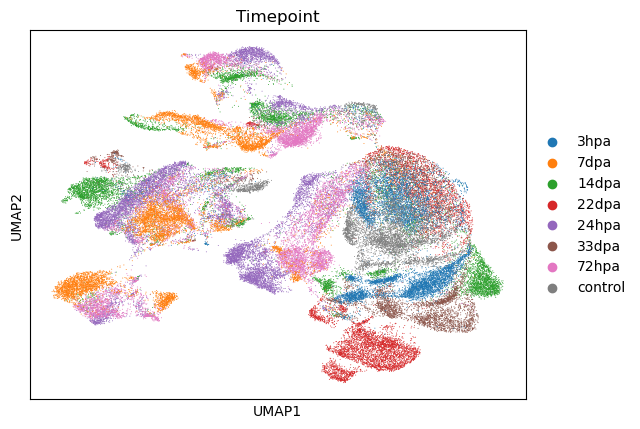

In [88]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'Timepoint')

umap_coords = adata.obsm['X_umap']



In [89]:
umap_coords = adata.obsm['X_umap']
# Extract cell IDs (from .obs_names or index)
cell_ids = adata.obs_names

# Extract the timepoint information (assuming it's stored in `adata.obs['timepoint']`)
timepoints = adata.obs['Timepoint']

# Create a DataFrame with cell IDs, timepoints, and UMAP coordinates
umap_df = pd.DataFrame({
    'Cell': cell_ids,
    'Timepoint': timepoints,
    'UMAP1': umap_coords[:, 0],  # First UMAP dimension
    'UMAP2': umap_coords[:, 1]   # Second UMAP dimension
})

# Save it as a CSV file
umap_df.to_csv('unintegrated_umap.csv', index=False)

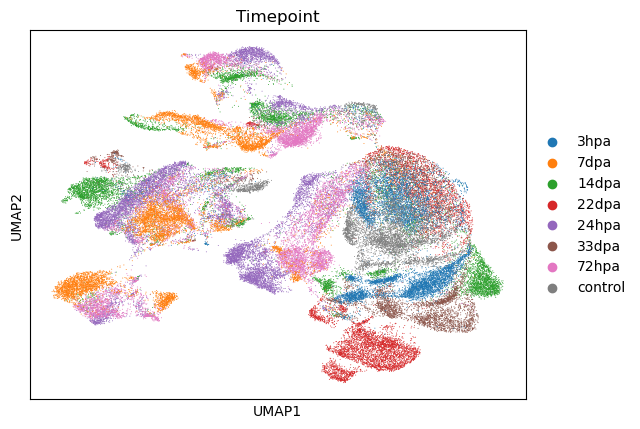

In [90]:
sc.pl.umap(adata, color='Timepoint')

In [451]:
adata.X=adata.layers['counts'].copy()

In [353]:
adata

AnnData object with n_obs × n_vars = 11194 × 10604
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [455]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['Timepoint'],
                       continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo', 'log1p_total_counts_s_phase', 
                                                  'log1p_total_counts_g2_phase', 'log1p_total_counts_m_phase', 
                                                  'log1p_total_counts_proliferation', 'log1p_total_counts_apoptosis_pro',
                                                 'log1p_total_counts_apoptosis_anti'])
tuner = ModelTuner(model_cls)

In [456]:
tuner.info()

ModelTuner registry for SCVI

                  Tunable hyperparameters                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃      Hyperparameter      ┃ Default value ┃    Source    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│         n_hidden         │      128      │     VAE      │
│         n_latent         │      10       │     VAE      │
│         n_layers         │       1       │     VAE      │
│       dropout_rate       │      0.1      │     VAE      │
│        dispersion        │     gene      │     VAE      │
│     log_variational      │     True      │     VAE      │
│     gene_likelihood      │     zinb      │     VAE      │
│   latent_distribution    │    normal     │     VAE      │
│    encode_covariates     │     False     │     VAE      │
│ deeply_inject_covariates │     True      │     VAE      │
│      use_batch_norm      │     both      │     VAE      │
│      use_layer_norm      │     none      │     VAE      │
│  use_observed_lib_size   │     True      │     VAE      │
│      var_activation      │     None      │     VAE      │
│        optimizer         │     Adam      │ TrainingPlan │
│            lr            │     0.001     │ TrainingPlan │
│       weight_decay       │     1e-06     │ TrainingPlan │
│           eps            │     0.01      │ TrainingPlan │
│    n_steps_kl_warmup     │     None      │ TrainingPlan │
│    n_epochs_kl_warmup    │      400      │ TrainingPlan │
│   reduce_lr_on_plateau   │     False     │ TrainingPlan │
│        lr_factor         │      0.6      │ TrainingPlan │
│       lr_patience        │      30       │ TrainingPlan │
│       lr_threshold       │      0.0      │ TrainingPlan │
│          lr_min          │       0       │ TrainingPlan │
│      max_kl_weight       │      1.0      │ TrainingPlan │
│      min_kl_weight       │      0.0      │ TrainingPlan │
│        batch_size        │      128      │     SCVI     │
└──────────────────────────┴───────────────┴──────────────┘

       Available metrics        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃     Metric      ┃    Mode    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ validation_loss │    min     │
└─────────────────┴────────────┘

                         Default search space                         
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃ Sample function ┃  Arguments  ┃ Keyword arguments ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│    n_hidden    │     choice      │ [[64, 128]] │        {}         │
└────────────────┴─────────────────┴─────────────┴───────────────────┘

In [457]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10,20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(['nb', 'zinb'])
}

In [458]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

True
2.3.0+cu121
12.1


In [459]:
results = tuner.fit(adata, metric='validation_loss',
                   resources = {'gpu': 1, 'cpu': 64},
                   search_space = search_space,
                   num_samples = 100,
                   max_epochs = 20,
                   reporter=True)

2024-10-16 19:24:36,413	INFO worker.py:1749 -- Started a local Ray instance.
2024-10-16 19:24:42,389	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2024-10-16 19:24:42,410	INFO tune.py:614 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(autoscaler +5h3m47s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +5h3m47s) Error: No available node types can fulfill resource request {'CPU': 64.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


2024-10-16 19:25:09,250	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-10-16 19:25:09,293	INFO tune.py:1004 -- Wrote the latest version of all result files and experiment state to '/work/vanaja_lab/griffin/projects/mphage/scripts/scvi_log/autotune/2024-10-16_19-24-17_scvi' in 0.0415s.
2024-10-16 19:25:09,313	INFO tune.py:1036 -- Total run time: 26.90 seconds (26.40 seconds for the tuning loop).
2024-10-16 19:25:09,314	WARNING tune.py:1051 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/work/vanaja_lab/griffin/projects/mphage/scripts/scvi_log/autotune/2024-10-16_19-24-17_scvi", trainable=...)
2024-10-16 19:25:09,333	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- _trainable_15f614b7: FileNotFoundError('Could not fetch me

In [ ]:
best_vl = 10000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']
    
    if vl < best_vl:
        best_vl = vl
        best_i = i
best_i
best_vl

In [ ]:
results.results[best_i]

In [9]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['Timepoint'],
                       continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo', 'log1p_total_counts_s_phase', 
                                                  'log1p_total_counts_g2_phase', 'log1p_total_counts_m_phase', 
                                                  'log1p_total_counts_proliferation', 'log1p_total_counts_apoptosis_pro',
                                                 'log1p_total_counts_apoptosis_anti'])

In [10]:
model = scvi.model.SCVI(adata, n_hidden=192, n_latent=50, n_layers=1, gene_likelihood='zinb')

In [11]:
kwargs = {'lr': 0.0037}

In [12]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/200:  50%|█████     | 100/200 [06:51<06:51,  4.12s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.64e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1868.205. Signaling Trainer to stop.


In [13]:
model.save(f'{init_anno}_model')

In [14]:
model = scvi.model.SCVI.load(f'{init_anno}_model/', adata)

INFO     File Mesenchymal_model/model.pt already downloaded                                                        


In [15]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

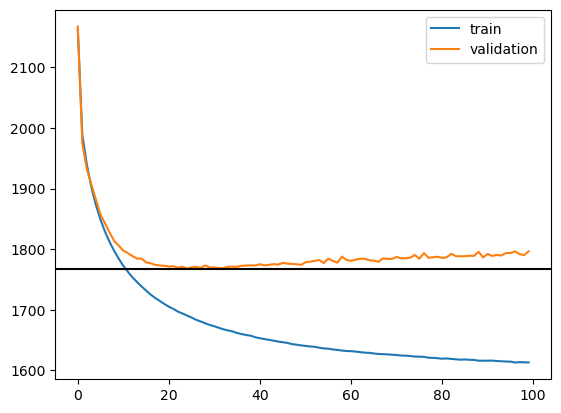

In [16]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [17]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [29]:
#adata.write_h5ad('../results/pp_adata/integrated.h5ad')

In [30]:
#adata = sc.read('../results/pp_adata/integrated.h5ad')

In [31]:
adata

AnnData object with n_obs × n_vars = 3239 × 6992
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'log1

In [18]:
sc.tl.pca(adata)

In [19]:
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [20]:
sc.tl.leiden(adata, resolution = 2, key_added = 'overcluster')

In [21]:
sc.tl.umap(adata)

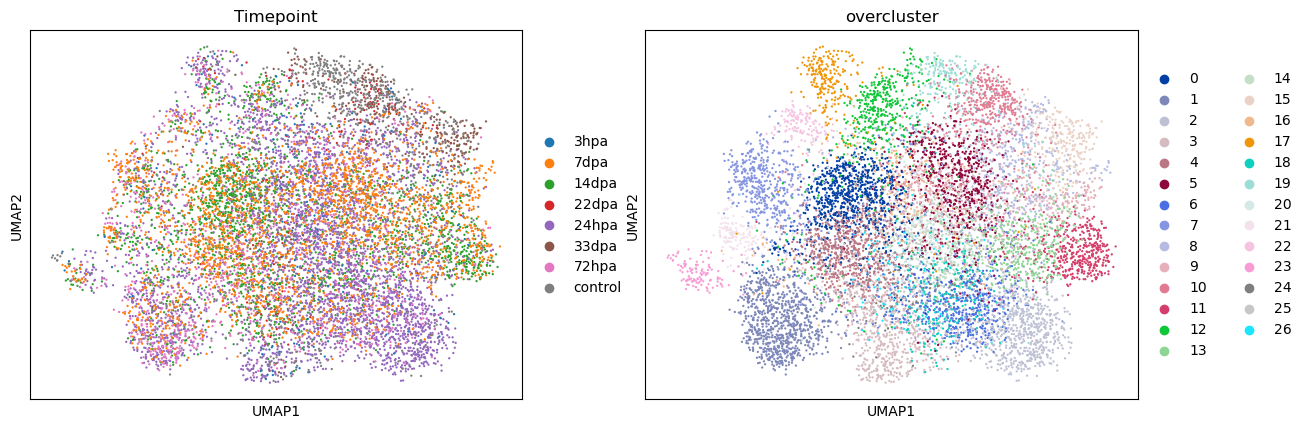

In [22]:
sc.pl.umap(adata, color = ['Timepoint', 'overcluster'])

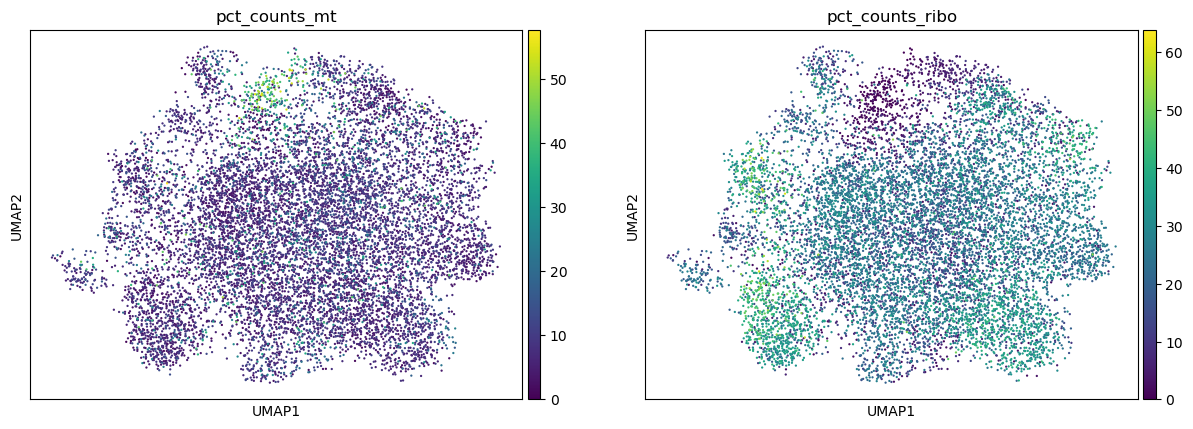

In [23]:
sc.pl.umap(adata, color = ['pct_counts_mt', 'pct_counts_ribo'])

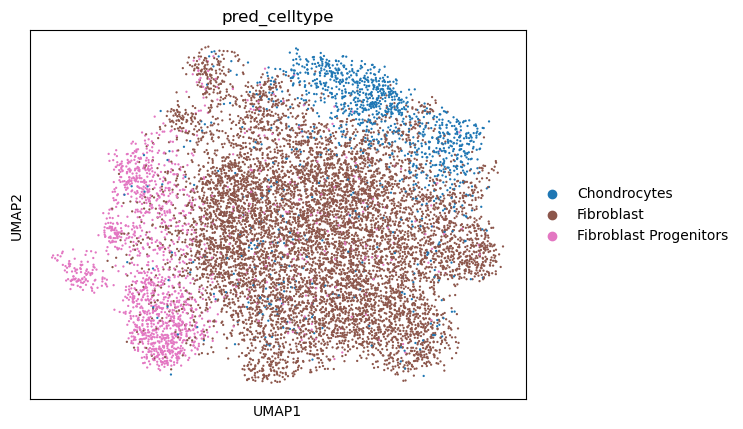

In [24]:
sc.pl.umap(adata, color = 'pred_celltype')

In [9]:
#adata.write_h5ad('../results/pp_adata/integrated.h5ad')

In [4]:
#adata = sc.read('../results/pp_adata/integrated.h5ad')

In [78]:
#adata

AnnData object with n_obs × n_vars = 65412 × 12198
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [14]:
# Extract cell IDs (from .obs_names or index)
cell_ids = adata.obs_names

# Extract the timepoint information (assuming it's stored in `adata.obs['timepoint']`)
timepoints = adata.obs['Timepoint']
overcluster = adata.obs['overcluster']

# Create a DataFrame with cell IDs, timepoints, and UMAP coordinates
umap_df = pd.DataFrame({
    'Cell': cell_ids,
    'Timepoint': timepoints,
    'Cluster' : overcluster,
    'UMAP1': umap_coords[:, 0],  # First UMAP dimension
    'UMAP2': umap_coords[:, 1]   # Second UMAP dimension
})

# Save it as a CSV file
umap_df.to_csv('integrated_umap.csv', index=False)

NameError: name 'umap_coords' is not defined

In [198]:
# Load the annotation file
annotation_df = pd.read_csv('../../axo_anno/scripts/updated_current_annotation_df.txt', sep='\t')

# Create a mapping dictionary for easy lookup
transcript_to_homolog = annotation_df.set_index('gene_id')['homolog'].to_dict()

# Add the homolog information to adata.var based on matching gene_id without any stripping
adata.var['homolog'] = adata.var['gene_id'].map(transcript_to_homolog)

# Check how many successful mappings were found
successful_mappings = adata.var['homolog'].notna().sum()
print(f"Number of successful mappings: {successful_mappings} / {len(adata.var)}")

# Save the updated AnnData object
#adata.write('../results/pp_adata/updated_integrated_with_homologs.h5ad')

Number of successful mappings: 11476 / 11485


In [199]:
adata.var

gene_id  \
LOC114789635[nr]|ZNF484[hs]_7          MSTRG.10516   
LOC114789697[nr]|N/A[hs]_9             MSTRG.10518   
LOC114789697[nr]|ZFP2[hs]_10           MSTRG.10519   
MSTRG.10523_14                         MSTRG.10523   
LOC115080625[nr]|ZNF777[hs]_16         MSTRG.10525   
...                                            ...   
AMEX60DD012272_27806                AMEX60DD012272   
LOC115531649[nr]|ERV3-2[hs]_27810   AMEX60DD012281   
TCTN3[hs_27814                      AMEX60DD012288   
N/A[nr]|FGL1[hs]_27821              AMEX60DD012297   
LOC115477350[nr]|NAALAD2[hs]_27827  AMEX60DD012303   

                                                       gene_name  n_cells  \
LOC114789635[nr]|ZNF484[hs]_7        LOC114789635[nr]|ZNF484[hs]     2428   
LOC114789697[nr]|N/A[hs]_9              LOC114789697[nr]|N/A[hs]      131   
LOC114789697[nr]|ZFP2[hs]_10           LOC114789697[nr]|ZFP2[hs]      146   
MSTRG.10523_14                                       MSTRG.10523      716   
LOC115080625[nr]|ZNF777[hs]_16       LOC115080625[nr]|ZNF777[hs]     1230   
...                                                          ...      ...   
AMEX60DD012272_27806                              AMEX60DD012272      258   
LOC115531649[nr]|ERV3-2[hs]_27810    LOC115531649[nr]|ERV3-2[hs]     2282   
TCTN3[hs_27814                                          TCTN3[hs      501   
N/A[nr]|FGL1[hs]_27821                          N/A[nr]|FGL1[hs]      111   
LOC115477350[nr]|NAALAD2[hs]_27827  LOC115477350[nr]|NAALAD2[hs]      519   

                                         homolog homologs  
LOC114789635[nr]|ZNF484[hs]_7             ZNF484   ZNF484  
LOC114789697[nr]|N/A[hs]_9          LOC114789697  Unknown  
LOC114789697[nr]|ZFP2[hs]_10                ZFP2     ZFP2  
MSTRG.10523_14                           unknown  Unknown  
LOC115080625[nr]|ZNF777[hs]_16           unknown   ZNF777  
...                                          ...      ...  
AMEX60DD012272_27806                     unknown  Unknown  
LOC115531649[nr]|ERV3-2[hs]_27810         ERV3-2   ERV3-2  
TCTN3[hs_27814                             TCTN3    TCTN3  
N/A[nr]|FGL1[hs]_27821                      FGL1     FGL1  
LOC115477350[nr]|NAALAD2[hs]_27827  LOC115477350  NAALAD2  

[11485 rows x 5 columns]

In [2]:
adata = sc.read(f'../results/annotated_adata.h5ad')

# Cell Type Annotation

In [3]:
adata = sc.read(f'../results/annotated_adata.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 64380 × 11485
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [4]:
import numpy as np

In [44]:
# Define the gene markers for which you want to find expression patterns
query_genes = ['CTSK[hs_1111', 'LOC115078508[nr]|CTSK[hs]_1113', 'MMP9[nr]|MMP2[hs]_8304', 'LOC116077264[nr]|CD300E[hs]_14776', 
               'HVCN1.S[nr]|HVCN1[hs]_22415', 'LOC115474732[nr]|ITGAM[hs]_8493', 'CD68[hs_209'] 

# Dictionary to store the average expression of each gene per cluster
avg_expression_per_gene = {}

# Loop through each query gene to calculate average expression in each cluster
for gene in query_genes:
    # Initialize a dictionary to hold average expressions per cluster for the current gene
    gene_avg_expression = {}
    
    # Loop through each cluster and calculate average expression
    for cluster in adata.obs['overcluster'].unique():
        # Get the subset of cells in the current cluster
        cluster_cells = adata[adata.obs['overcluster'] == cluster]
        
        # Calculate the average expression of the gene in this cluster
        avg_expression = cluster_cells[:, gene].X.mean()
        gene_avg_expression[cluster] = avg_expression
    
    # Sort clusters by average expression of the gene in descending order
    avg_expression_per_gene[gene] = sorted(gene_avg_expression.items(), key=lambda x: x[1], reverse=True)

# Convert results to a DataFrame for better visualization
avg_expression_df = pd.DataFrame({
    gene: [f"Cluster {cluster}: {expr:.2f}" for cluster, expr in clusters]
    for gene, clusters in avg_expression_per_gene.items()
})

avg_expression_df

CTSK[hs_1111 LOC115078508[nr]|CTSK[hs]_1113 MMP9[nr]|MMP2[hs]_8304  \
0    Cluster 2: 2.68                Cluster 2: 3.38        Cluster 2: 3.44   
1   Cluster 10: 0.93                Cluster 5: 1.03        Cluster 0: 3.26   
2    Cluster 5: 0.70               Cluster 10: 0.72        Cluster 9: 2.20   
3    Cluster 4: 0.67                Cluster 4: 0.42        Cluster 5: 1.64   
4    Cluster 1: 0.47                Cluster 1: 0.20       Cluster 10: 1.64   
5    Cluster 6: 0.39                Cluster 7: 0.18        Cluster 3: 1.30   
6    Cluster 7: 0.28                Cluster 9: 0.16       Cluster 11: 1.29   
7    Cluster 3: 0.23               Cluster 11: 0.15        Cluster 4: 1.02   
8   Cluster 11: 0.23                Cluster 3: 0.12        Cluster 6: 0.89   
9    Cluster 9: 0.12                Cluster 6: 0.10        Cluster 7: 0.88   
10   Cluster 8: 0.05                Cluster 8: 0.08        Cluster 1: 0.57   
11   Cluster 0: 0.02                Cluster 0: 0.07        Cluster 8: 0.21   

   LOC116077264[nr]|CD300E[hs]_14776 HVCN1.S[nr]|HVCN1[hs]_22415  \
0                    Cluster 6: 1.43             Cluster 0: 0.97   
1                    Cluster 1: 1.38            Cluster 11: 0.46   
2                    Cluster 3: 1.21             Cluster 9: 0.42   
3                   Cluster 11: 0.88             Cluster 5: 0.29   
4                    Cluster 4: 0.82            Cluster 10: 0.27   
5                    Cluster 7: 0.62             Cluster 3: 0.22   
6                   Cluster 10: 0.52             Cluster 7: 0.17   
7                    Cluster 2: 0.45             Cluster 1: 0.15   
8                    Cluster 9: 0.34             Cluster 6: 0.14   
9                    Cluster 5: 0.25             Cluster 2: 0.08   
10                   Cluster 0: 0.13             Cluster 4: 0.08   
11                   Cluster 8: 0.03             Cluster 8: 0.03   

   LOC115474732[nr]|ITGAM[hs]_8493       CD68[hs_209  
0                  Cluster 4: 0.13   Cluster 4: 1.65  
1                  Cluster 0: 0.10   Cluster 1: 1.38  
2                  Cluster 9: 0.08   Cluster 9: 1.25  
3                  Cluster 3: 0.05   Cluster 6: 1.19  
4                 Cluster 11: 0.05   Cluster 3: 1.11  
5                 Cluster 10: 0.04  Cluster 11: 1.01  
6                  Cluster 1: 0.04   Cluster 2: 0.85  
7                  Cluster 6: 0.04   Cluster 7: 0.74  
8                  Cluster 7: 0.02  Cluster 10: 0.68  
9                  Cluster 5: 0.01   Cluster 0: 0.63  
10                 Cluster 2: 0.01   Cluster 5: 0.43  
11                 Cluster 8: 0.00   Cluster 8: 0.04

In [32]:
print("\nSignificant Clusters for Each Gene (FDR < 0.05):")
for gene, info in significant_clusters_per_gene.items():
    print(f"Gene: {gene}")
    print(f"Significant Clusters: {info['clusters']}")
    print(f"Log-Fold Changes: {info['logfoldchanges']}")
    print("\n")


Significant Clusters for Each Gene (FDR < 0.05):


In [4]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [7]:
adata.var

gene_id  \
LOC114789635[nr]|ZNF484[hs]_7          MSTRG.10516   
LOC114789697[nr]|N/A[hs]_9             MSTRG.10518   
LOC114789697[nr]|ZFP2[hs]_10           MSTRG.10519   
MSTRG.10523_14                         MSTRG.10523   
LOC115080625[nr]|ZNF777[hs]_16         MSTRG.10525   
...                                            ...   
AMEX60DD012272_27806                AMEX60DD012272   
LOC115531649[nr]|ERV3-2[hs]_27810   AMEX60DD012281   
TCTN3[hs_27814                      AMEX60DD012288   
N/A[nr]|FGL1[hs]_27821              AMEX60DD012297   
LOC115477350[nr]|NAALAD2[hs]_27827  AMEX60DD012303   

                                                       gene_name  n_cells  \
LOC114789635[nr]|ZNF484[hs]_7        LOC114789635[nr]|ZNF484[hs]     2428   
LOC114789697[nr]|N/A[hs]_9              LOC114789697[nr]|N/A[hs]      131   
LOC114789697[nr]|ZFP2[hs]_10           LOC114789697[nr]|ZFP2[hs]      146   
MSTRG.10523_14                                       MSTRG.10523      716   
LOC115080625[nr]|ZNF777[hs]_16       LOC115080625[nr]|ZNF777[hs]     1230   
...                                                          ...      ...   
AMEX60DD012272_27806                              AMEX60DD012272      258   
LOC115531649[nr]|ERV3-2[hs]_27810    LOC115531649[nr]|ERV3-2[hs]     2282   
TCTN3[hs_27814                                          TCTN3[hs      501   
N/A[nr]|FGL1[hs]_27821                          N/A[nr]|FGL1[hs]      111   
LOC115477350[nr]|NAALAD2[hs]_27827  LOC115477350[nr]|NAALAD2[hs]      519   

                                         homolog homologs  
LOC114789635[nr]|ZNF484[hs]_7             ZNF484   ZNF484  
LOC114789697[nr]|N/A[hs]_9          LOC114789697  Unknown  
LOC114789697[nr]|ZFP2[hs]_10                ZFP2     ZFP2  
MSTRG.10523_14                           unknown  Unknown  
LOC115080625[nr]|ZNF777[hs]_16            ZNF777   ZNF777  
...                                          ...      ...  
AMEX60DD012272_27806                     unknown  Unknown  
LOC115531649[nr]|ERV3-2[hs]_27810         ERV3-2   ERV3-2  
TCTN3[hs_27814                             TCTN3    TCTN3  
N/A[nr]|FGL1[hs]_27821                      FGL1     FGL1  
LOC115477350[nr]|NAALAD2[hs]_27827  LOC115477350  NAALAD2  

[11485 rows x 5 columns]

In [17]:
def plot_umap_with_genes(adata, gene_names):
    """
    Plot UMAPs for query genes in a single figure with cleaned gene names,
    shared legend, and custom UMAP-style axes.
    """
    # Find genes that match the input gene names
    gene_matches = []
    gene_names_cleaned = []
    missing_genes = []

    # Match and clean gene names
    for gene_name in gene_names:
        gene_name_lower = gene_name.lower()

        # Find matching genes
        matches = adata.var.index[
            adata.var['gene_name'].astype(str).str.lower().str.contains(gene_name_lower, na=False)
        ].tolist()

        if matches:
            for match in matches:
                # Clean gene name using regex (remove everything after the last underscore)
                cleaned_name = re.sub(r'_(?!.*_).*$', '', match)
                gene_matches.append(match)
                gene_names_cleaned.append(cleaned_name)
        else:
            missing_genes.append(gene_name)

    # Report missing genes
    if missing_genes:
        print(f"No matches found for these gene names: {', '.join(missing_genes)}")

    # Plot UMAPs for matched genes
    if gene_matches:
        num_genes = len(gene_matches)
        fig, axes = plt.subplots(1, num_genes, figsize=(5 * num_genes, 5), constrained_layout=True)

        if num_genes == 1:
            axes = [axes]  # Ensure axes is iterable for a single plot

        for i, (gene, cleaned_name) in enumerate(zip(gene_matches, gene_names_cleaned)):
            ax = axes[i]
            # Plot UMAP for the gene
            sc.pl.umap(adata, color=gene, ax=ax, show=False, legend_loc='right', s=10)
            
            # Customize axis with UMAP-style markers
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            ax.annotate('UMAP1', xy=(0.5, -0.1), xycoords='axes fraction', ha='center', fontsize=10)
            ax.annotate('UMAP2', xy=(-0.1, 0.5), xycoords='axes fraction', rotation=90, va='center', fontsize=10)
            ax.set_title(f"{cleaned_name}")

        # Add a single shared legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right", title="Gene Expression")
        
        plt.suptitle("UMAP Gene Expression", fontsize=16)
        plt.show()

def query_genes(query_genes):
    for query_gene in query_genes:
        # Convert the query gene to lowercase for case-insensitive matching
        query_gene_lower = query_gene.lower()

        # Ensure gene_name column is treated as strings and check for substring matches
        axolotl_genes = adata.var.index[adata.var['gene_name'].astype(str).str.lower().str.contains(query_gene_lower, na=False)].tolist()
        print(f"Axolotl genes corresponding to '{query_gene}':", axolotl_genes)

        if axolotl_genes:
            plot_umap_with_genes(adata, [query_gene])


Axolotl genes corresponding to 'trap': ['TRAPPC1[hs_368', 'TRAP1[nr]|N/A[hs]_4791', 'TRAPPC12[hs_10570', 'TRAPPC10[hs_17428', 'TRAPPC4[hs_21069', 'STRAP.L[nr]|STRAP[hs]_25321', 'TRAPPC6B[nr]|N/A[hs]_26840']


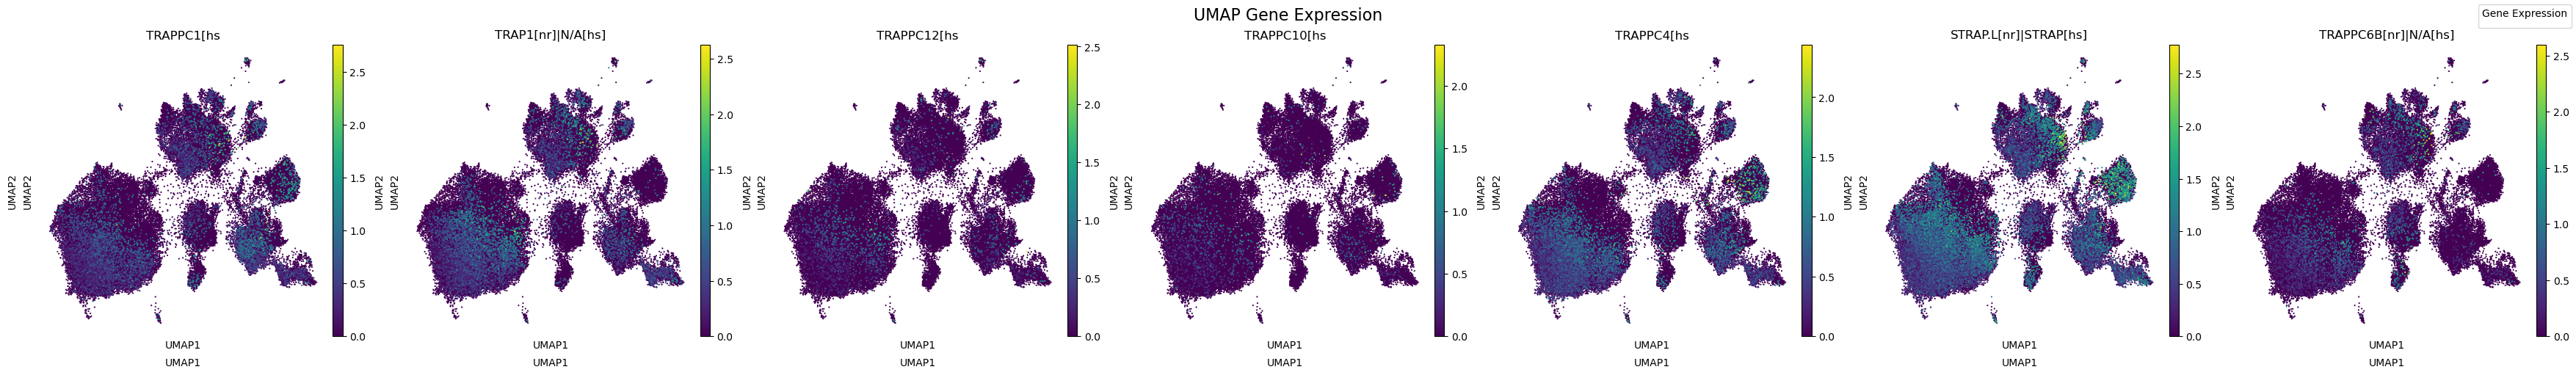

Axolotl genes corresponding to 'traf': ['TRAF7[hs_5103', 'TRAF1[hs_19434', 'TRAFD1[hs_22438', 'TRAF3IP3[hs_25903', 'RTRAF[hs_26856', 'TRAF3[hs_27248']


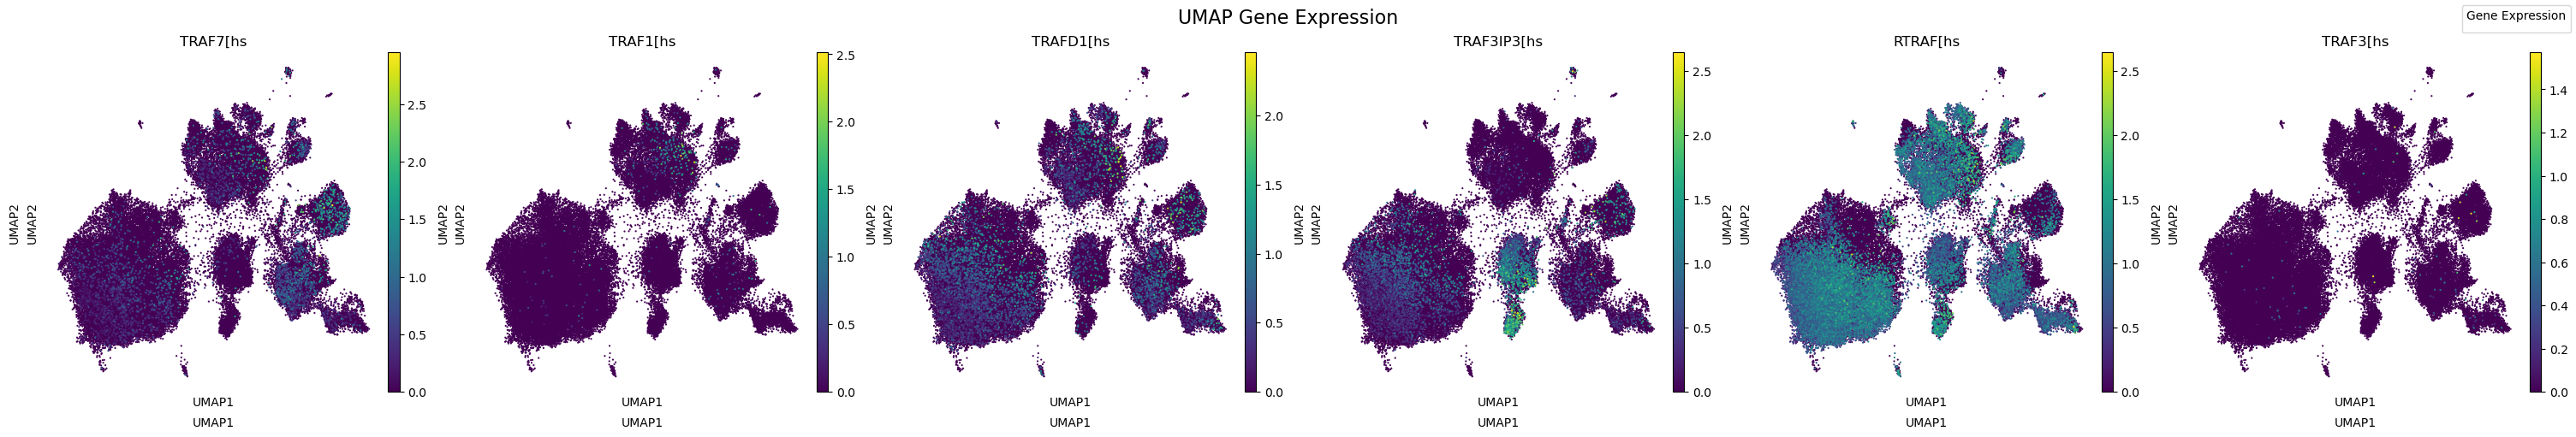

In [18]:
query_genes(['trap', 'traf'])

In [36]:
import numpy as np
import pandas as pd
import os
import re

def analyze_gene_expression_combined(adata, query_genes, output_file="../results/gene_expression_results.csv"):
    """
    Analyze the average expression and enrichment score for each query gene across overclusters.
    Enrichment score = (Mean Cluster Expression - Global Mean Expression) / Standard Deviation of Expression in All Clusters.
    Gene names are processed to remove underscores and everything after them.
    Saves all results to a single CSV file.
    """
    # Ensure the results directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # List to store results for all genes
    combined_results = []

    for query_gene in query_genes:
        # Convert the query gene to lowercase for case-insensitive matching
        query_gene_lower = query_gene.lower()

        # Find matching genes in the adata.var['gene_name']
        matched_genes = adata.var.index[adata.var['gene_name'].astype(str).str.lower().str.contains(query_gene_lower, na=False)].tolist()

        if not matched_genes:
            print(f"No matches found for '{query_gene}'. Skipping.")
            continue
        
        print(f"Processing gene(s) matching '{query_gene}': {matched_genes}")
        
        # Process each matched gene
        for gene in matched_genes:
            # Edit gene name to remove underscores and everything after them
            processed_gene_name = re.sub(r'_(?!.*_)', '', gene)

            # Get the expression values for the gene from the specified layer
            gene_expression = adata[:, gene].layers['scVI_normalized'].toarray().flatten() if hasattr(adata[:, gene].layers['scVI_normalized'], "toarray") else adata[:, gene].layers['scVI_normalized'].flatten()
            
            # Group by overclusters and calculate average expression
            overcluster_groups = adata.obs['overcluster']
            avg_expression = pd.DataFrame({
                'overcluster': overcluster_groups,
                'expression': gene_expression
            }).groupby('overcluster')['expression'].mean()
            
            # Calculate global mean and standard deviation
            global_mean = gene_expression.mean()
            global_std = gene_expression.std()

            # Calculate enrichment score for the gene
            enrichment_scores = (avg_expression - global_mean) / global_std

            # Append results to the combined list
            for cluster, avg_expr, enrichment_score in zip(avg_expression.index, avg_expression.values, enrichment_scores.values):
                combined_results.append({
                    'gene': processed_gene_name,
                    'overcluster': cluster,
                    'average_expression': avg_expr,
                    'enrichment_score': enrichment_score
                })

    # Create a DataFrame from the combined results
    results_df = pd.DataFrame(combined_results)

    # Save all results to a single CSV file
    results_df.to_csv(output_file, index=False)
    print(f"All results saved to {output_file}.")


In [19]:
import scanpy as sc
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

def find_highest_coexpressed_genes(adata, query_genes, top_n=10):
    """
    Find genes with the highest Pearson coexpression for a given set of query genes.
    
    Parameters:
        adata (AnnData): The annotated data matrix.
        query_genes (list): List of gene names to query.
        top_n (int): Number of top coexpressed genes to return.
        
    Returns:
        dict: A dictionary of query genes and their top coexpressed genes with correlations.
    """
    # Step 1: Search for approximate matches and clean gene names
    gene_matches = []
    cleaned_gene_names = []
    missing_genes = []

    for gene_name in query_genes:
        gene_name_lower = gene_name.lower()
        matches = adata.var.index[
            adata.var['gene_name'].astype(str).str.lower().str.contains(gene_name_lower, na=False)
        ].tolist()

        if matches:
            for match in matches:
                # Clean gene name: remove everything after the last underscore
                cleaned_name = re.sub(r'_(?!.*_).*$', '', match)
                gene_matches.append(match)
                cleaned_gene_names.append(cleaned_name)
        else:
            missing_genes.append(gene_name)
    
    # Step 2: Find Pearson coexpression
    results = {}
    if not gene_matches:
        print("No matching genes found.")
        return results

    # Subset the data to the matched genes
    gene_indices = [adata.var.index.get_loc(gene) for gene in gene_matches]
    expression_data = adata[:, gene_indices].X.toarray() if hasattr(adata[:, gene_indices].X, "toarray") else adata[:, gene_indices].X

    # Calculate correlations
    full_expression = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    for i, gene_name in enumerate(gene_matches):
        correlations = np.corrcoef(expression_data[:, i], full_expression, rowvar=False)[0, 1:]
        sorted_indices = np.argsort(-correlations)  # Descending order

        top_genes = adata.var.index[sorted_indices[:top_n]].tolist()
        top_correlations = correlations[sorted_indices[:top_n]]

        results[cleaned_gene_names[i]] = list(zip(top_genes, top_correlations))

    # Step 3: Display results
    for gene, coexpressed in results.items():
        print(f"Top {top_n} genes coexpressed with {gene}:")
        for g, corr in coexpressed:
            print(f"    {g}: {corr:.4f}")
    
    if missing_genes:
        print("\nThe following genes had no matches:", missing_genes)

    return results

def plot_coexpression_matrices(adata, query_genes, results, top_n=10, output_pdf="coexpression_matrices.pdf"):
    """
    Generate and save heatmaps for the coexpression matrices of query genes.
    
    Parameters:
        adata (AnnData): Annotated data matrix.
        query_genes (list): List of gene names to query.
        results (dict): Dictionary of top coexpressed genes per query.
        top_n (int): Number of top coexpressed genes.
        output_pdf (str): Output PDF file path.
    """
    with PdfPages(output_pdf) as pdf:
        for query_gene, top_genes_info in results.items():
            top_genes = [g for g, _ in top_genes_info]
            genes_to_plot = [query_gene] + top_genes

            # Subset expression matrix for selected genes
            valid_genes = [gene for gene in genes_to_plot if gene in adata.var.index]
            if not valid_genes:
                continue

            expression_subset = adata[:, valid_genes].X.toarray() if hasattr(adata[:, valid_genes].X, "toarray") else adata[:, valid_genes].X

            # Calculate the correlation matrix
            correlation_matrix = np.corrcoef(expression_subset, rowvar=False)

            # Create the heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(
                correlation_matrix,
                xticklabels=valid_genes,
                yticklabels=valid_genes,
                annot=True,
                fmt=".2f",
                cmap="coolwarm",
                cbar_kws={"shrink": 0.5}
            )
            plt.title(f"Coexpression Matrix for {query_gene}")
            plt.tight_layout()

            # Save to the PDF
            pdf.savefig()
            plt.close()

        print(f"Saved coexpression matrices to {output_pdf}")

# Example usage:
# Assuming 'adata' is your AnnData object and 'query_genes' is the list of queried genes
query_genes = ['MMP9', 'CTSK', 'STAMP', 'TNFRSF11A']
results = find_highest_coexpressed_genes(adata, query_genes, top_n=20)
plot_coexpression_matrices(adata, query_genes, results, top_n=10, output_pdf="coexpression_matrices.pdf")


Top 20 genes coexpressed with MMP9[nr]|MMP2[hs]:
    MMP9[nr]|MMP2[hs]_8304: 1.0000
    LOC115080567[nr]|BTN3A1[hs]_8557: 0.5267
    LOC115094232[nr]_8725: 0.5262
    MSTRG.18173_8689: 0.5247
    LOC115476040[nr]_1668: 0.5089
    MSTRG.12501_1992: 0.5037
    CD53[hs_25750: 0.4992
    FBP1[hs_15537: 0.4983
    MSTRG.8591_25896: 0.4757
    PROD1[nr]_8600: 0.4735
    LLAP_18947[nr]|N/A[hs]_25992: 0.4696
    ANGPTL4[hs_1082: 0.4581
    USP2[hs_21047: 0.4557
    TNFRSF1B[hs_19672: 0.4536
    LOC115078508[nr]|CTSK[hs]_1113: 0.4531
    CYBB.L[nr]|CYBB[hs]_17849: 0.4462
    CORO1A[hs_8709: 0.4408
    LOC115374818[nr]_1718: 0.4395
    MSTRG.17891_8407: 0.4353
    LOC115078641[nr]|ASTL[hs]_25994: 0.4349
Top 20 genes coexpressed with CTSK[hs:
    CTSK[hs_1111: 1.0000
    LOC115078508[nr]|CTSK[hs]_1113: 0.6952
    N/A[nr]|CKB[hs]_26535: 0.6027
    TREML1[nr]_26025: 0.5726
    LOC115084591[nr]|CCR1[hs]_12987: 0.5499
    CA7[nr]|N/A[hs]_1403: 0.5409
    MSTRG.20963_10847: 0.4951
    MSTRG.10008_2670

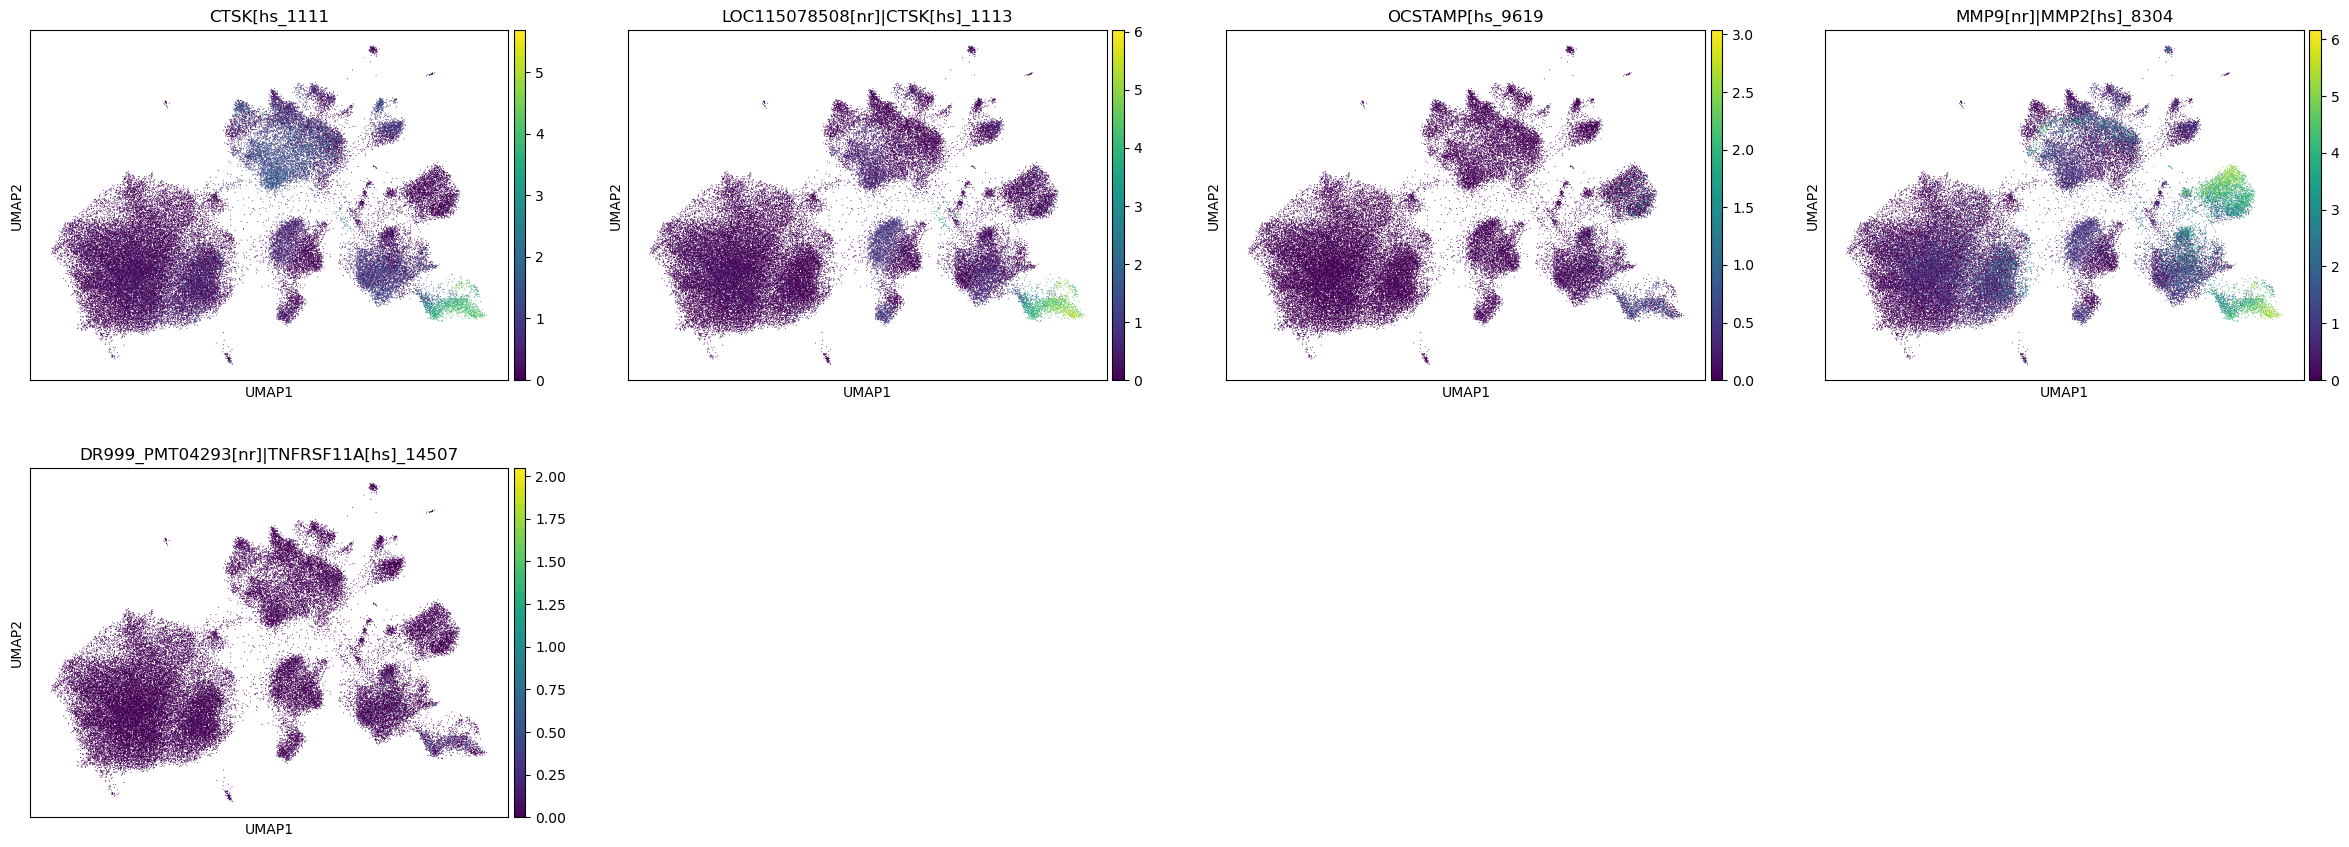

In [82]:
sc.pl.umap(adata, color=['CTSK[hs_1111', 'LOC115078508[nr]|CTSK[hs]_1113', 'OCSTAMP[hs_9619', 'MMP9[nr]|MMP2[hs]_8304', 'DR999_PMT04293[nr]|TNFRSF11A[hs]_14507'])

In [8]:
def extract_homologs(adata):
    # Function to extract gene name before specified tags ([hs])
    def extract_hs(name):
        # Find the gene name before [hs] and ensure it doesn't include N/A
        match = re.search(r"([^|]+)\[hs", name)  # Extract the part before [hs]
        if match and match.group(1) != "N/A":  # Exclude "N/A"
            return match.group(1)
        return "Unknown"

    # Create new column for human homologs with "Unknown" as default
    adata.var["homologs"] = [extract_hs(name) for name in adata.var_names]

    return adata  # Return the modified AnnData object
adata = extract_homologs(adata)

In [4]:
adata.obs['overcluster']

14dpa.h5ad_GTTAAGCGTATAGTAG       2
14dpa.h5ad_CATCAAGCAAAGCGGT       2
14dpa.h5ad_ATCGAGTCACCTATCC      35
14dpa.h5ad_AGTCTTTGTCGCATCG      13
14dpa.h5ad_CGTTGGGAGAACTCGG       2
                                 ..
control.h5ad_GTCTCGTTCCCAACGG    21
control.h5ad_AAGGCAGCATACGCCG    21
control.h5ad_CTACGTCGTGAGGCTA     4
control.h5ad_GTCGGGTAGATCACGG    21
control.h5ad_CCGTACTCATTGTGCA    15
Name: overcluster, Length: 64380, dtype: category
Categories (62, object): ['0', '1', '2', '3', ..., '58', '59', '60', '61']

In [9]:
#sc.tl.leiden(adata, resolution = 4, key_added = 'overcluster')

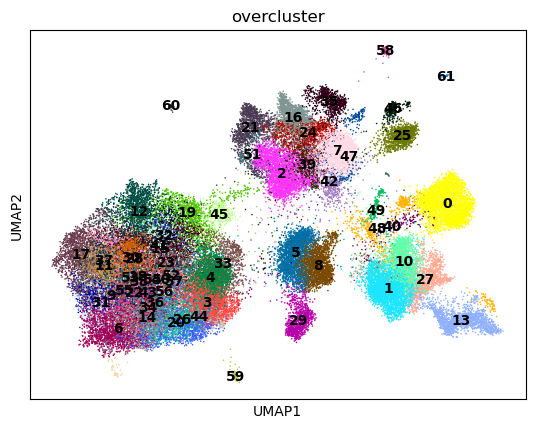

In [3]:
sc.pl.umap(adata, color = ['overcluster'], legend_loc = 'on data', s = 5)

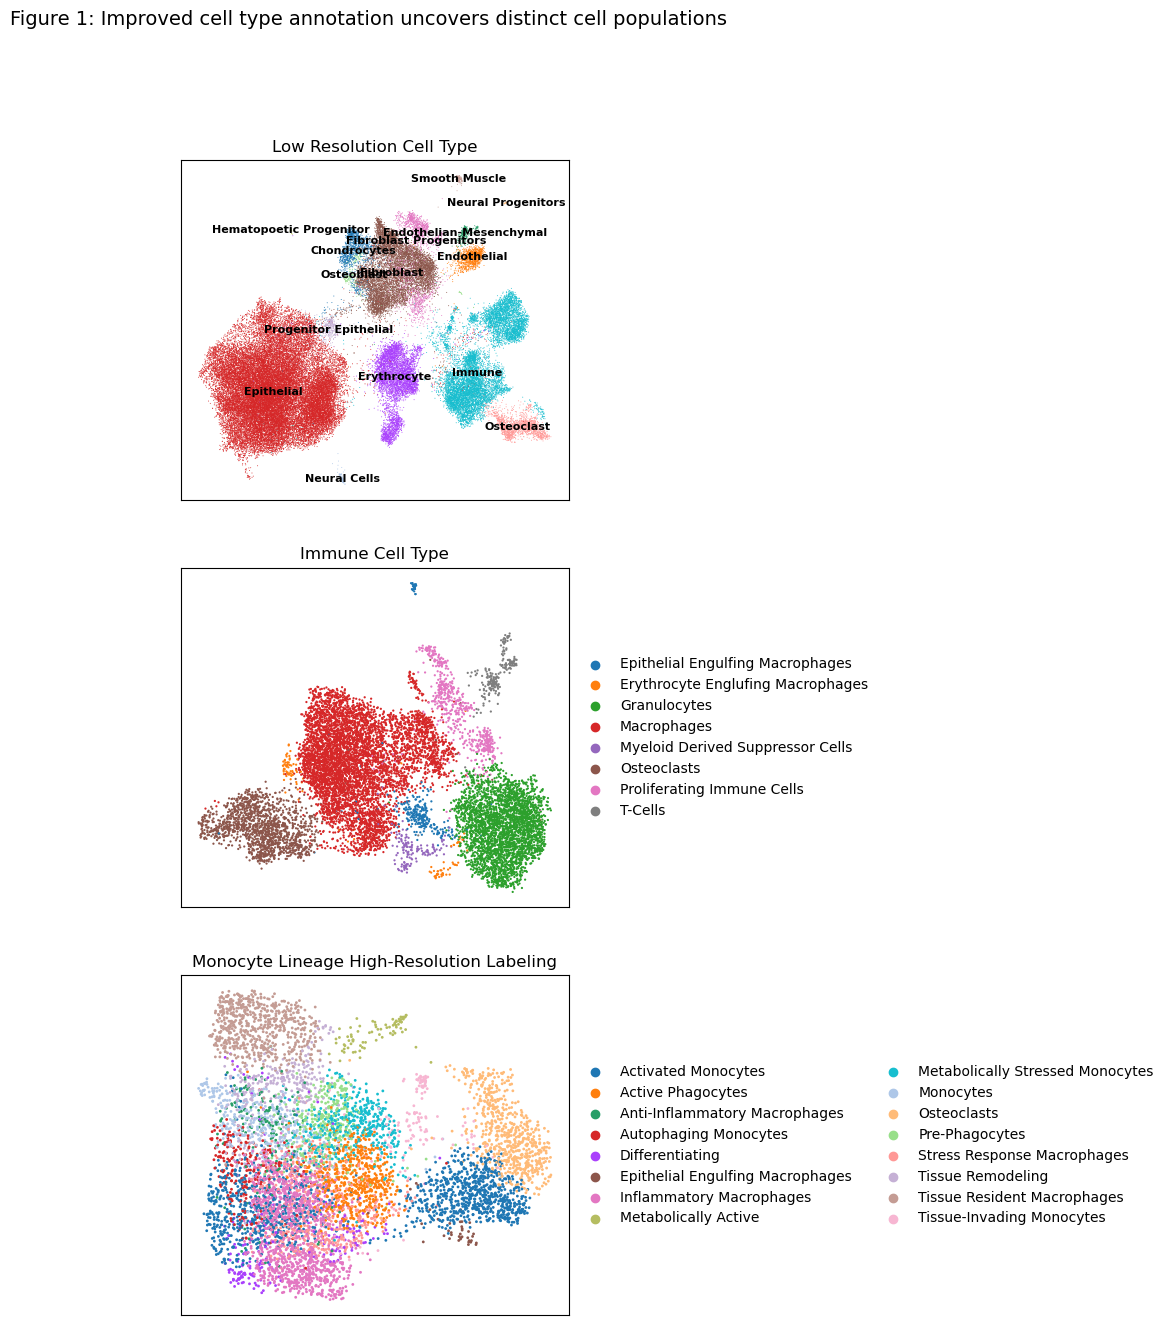

In [50]:
import matplotlib.pyplot as plt
import scanpy as sc

# Set up a single-column figure with three subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))  # Adjust figsize for spacing
fig.suptitle('Figure 1: Improved cell type annotation uncovers distinct cell populations', fontsize=14)

# Plot 1: Low Resolution Cell Type
sc.pl.umap(adata, color='pred_celltype', title='Low Resolution Cell Type', show=False, 
           legend_loc='on data', legend_fontsize=8, ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Plot 2: Immune Cell Type
sc.pl.umap(immune_adata, color='pred_celltype', legend_fontsize=10, show=False, 
           title='Immune Cell Type', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Plot 3: Monocyte Lineage High-Resolution Labeling
sc.pl.umap(mono_adata, color='overcluster_cell_type', legend_fontsize=10, show=False, 
           title='Monocyte Lineage High-Resolution Labeling', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()


In [30]:
immune_adata = sc.read_h5ad('../results/annotations/level_2/annotated_immune_adata.h5ad')
immune_adata

AnnData object with n_obs × n_vars = 11646 × 10035
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

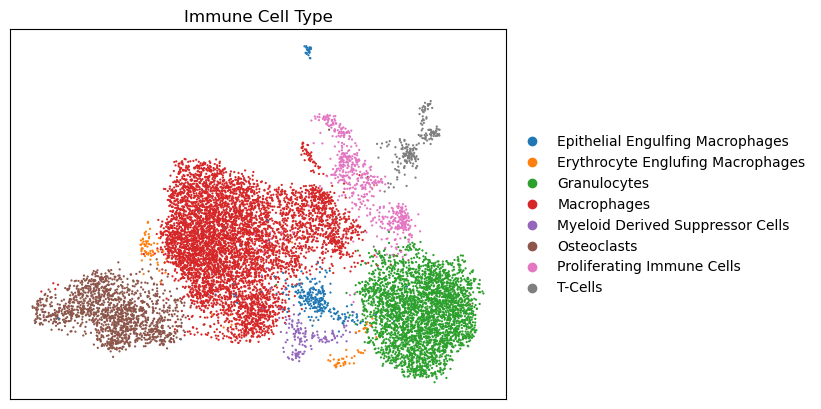

In [47]:
sc.pl.umap(immune_adata, color = 'pred_celltype', legend_fontsize = '10', show = False, title = 'Immune Cell Type')

ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [37]:
mono_adata = sc.read_h5ad('../results/annotations/level_3/annotated_monocyte_adata.h5ad')
mono_adata

AnnData object with n_obs × n_vars = 7319 × 9492
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'log1

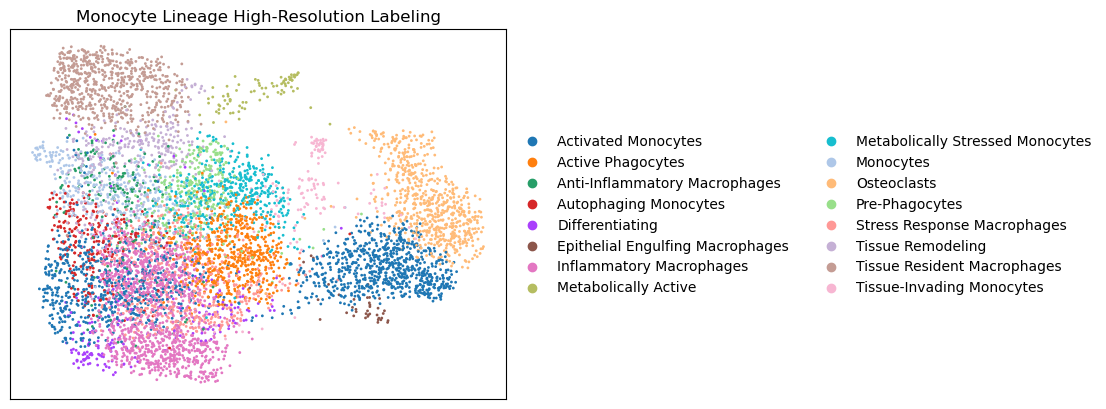

In [45]:
sc.pl.umap(mono_adata, color = 'overcluster_cell_type', legend_fontsize = '10', show = False, title = 'Monocyte Lineage High-Resolution Labeling')

ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

def analyze_cluster(adata, cluster, gene_name=None, palette_umap='lightgrey', highlight_color='k', bar_color='black', total_bar_color='lightgrey'):
    # Set up the figure with appropriate size
    fig = plt.figure(figsize=(18, 12))

    # Title: Small section at the top left
    ax_title = fig.add_axes([0.05, 0.95, 0.25, 0.03])  # [left, bottom, width, height]
    ax_title.axis('off')  # Turn off axis for the title space
    ax_title.text(0, 0.5, f"Cluster {cluster} Analysis", fontsize=20, fontweight='bold', va='center', ha='left')

    # Table: Takes up 70% of the height and 1/3 of the width on the left
    ax_table = fig.add_axes([0.05, 0.25, 0.25, 0.7])  # [left, bottom, width, height]
    ax_table.axis('off')

    # Bar Chart: Bottom 20% of the height and 1/3 of the width on the left
    ax_bar = fig.add_axes([0.05, 0.05, 0.25, 0.2])  # [left, bottom, width, height]

    # Adjusted positions for better alignment and spacing of the UMAPs
    # Top UMAP: Top half of the height and 2/3 of the width on the right
    ax_umap_top = fig.add_axes([0.35, 0.52, 0.6, 0.42], aspect='equal')  # Adjusted position

    # Bottom UMAP: Bottom half of the height and 2/3 of the width on the right
    ax_umap_bottom = fig.add_axes([0.35, 0.06, 0.6, 0.42], aspect='equal')  # Adjusted position

    # UMAP Plot: All cells in light grey, cluster cells in black
    sc.pl.umap(adata, palette=palette_umap, show=False, ax=ax_umap_top, title=None, size=10, edges=False)  # Suppress the title
    sc.pl.umap(
        adata[adata.obs.overcluster == cluster],
        color='overcluster',
        ax=ax_umap_top,
        legend_loc=None,
        palette=[highlight_color],
        size=5,
        show=False
    )
    ax_umap_top.set_xlabel('')  # Remove x-axis label
    ax_umap_top.set_ylabel('')  # Remove y-axis label

    # Handle the bottom UMAP based on the gene_name parameter
    if gene_name:
        # Find the gene(s) that match the homolog name
        gene_matches = adata.var.index[adata.var['homologs'] == gene_name].tolist()

        if gene_matches:
            # If multiple matches found, use the first match to avoid error
            selected_gene = gene_matches[0]
            sc.pl.umap(adata, color=selected_gene, ax=ax_umap_bottom, legend_loc='on data', s=5, show=False, layer = 'scVI_normalized')
            ax_umap_bottom.set_title(f"{gene_name} (showing: {selected_gene})")  # Set title with additional info
        else:
            # Display message if no homolog is found
            ax_umap_bottom.text(0.5, 0.5, f'No match found for homolog: {gene_name}', ha='center', va='center', fontsize=12, color='grey')
            ax_umap_bottom.axis('off')
    else:
        # Placeholder for the bottom UMAP if no gene_name is provided
        ax_umap_bottom.text(0.5, 0.5, 'UMAP Placeholder', ha='center', va='center', fontsize=12, color='grey')
        ax_umap_bottom.axis('off')
    
    # Remove x and y labels from the bottom UMAP
    ax_umap_bottom.set_xlabel('')
    ax_umap_bottom.set_ylabel('')
    
    # Bar Plot: Number of cells in cluster across timepoints
    # Order for Timepoints
    timepoint_order = ['control', '3hpa', '24hpa', '72hpa', '7dpa', '14dpa', '22dpa', '33dpa']
    
    # Compute total cells across all clusters for each timepoint
    total_counts = (
        adata.obs
        .groupby('Timepoint')
        .size()
        .reindex(timepoint_order, fill_value=0)
        .reset_index(name='Total Count')
    )
    
    # Compute cells in specific cluster across timepoints
    cluster_counts = (
        adata.obs[adata.obs['overcluster'] == cluster]
        .groupby('Timepoint')
        .size()
        .reindex(timepoint_order, fill_value=0)
        .reset_index(name='Cluster Count')
    )
    
    # Merge total and cluster counts
    counts = pd.merge(total_counts, cluster_counts, on='Timepoint', how='left').fillna(0)
    
    # Plot total cells as background bars in lightgrey
    ax_bar.bar(counts['Timepoint'], counts['Total Count'], color=total_bar_color, label='Total Cells')
    
    # Overlay cluster cell counts as black bars
    bars = ax_bar.bar(counts['Timepoint'], counts['Cluster Count'], color=bar_color, label='Cluster Cells')

    # Remove y-axis labels and ticks
    ax_bar.set_yticks([])
    ax_bar.set_ylabel('')

    # Annotate each bar with the count value
    for bar, count in zip(bars, counts['Cluster Count']):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}', ha='center', va='bottom')

    ax_bar.set_xlabel('')  # Remove x-axis label
    ax_bar.legend()
    
    # DE Genes Table: Calculate differentially expressed genes, add layer scVI_normalized for more accurate but slower ranking
    sc.tl.rank_genes_groups(adata, groupby='overcluster', groups=[cluster], reference='rest', layer = 'scVI_normalized')
    result = adata.uns['rank_genes_groups']
    de_genes = pd.DataFrame({
        'Gene': result['names'][cluster],
        'Score': result['scores'][cluster]
    })

    # Round the 'Score' to two decimal places
    de_genes['Score'] = de_genes['Score'].astype(float).round(2)

    # Merge DE genes with homolog data, checking if 'homolog' is in adata.var
    if 'homologs' in adata.var.columns:
        de_genes = de_genes.merge(adata.var[['homologs']], left_on='Gene', right_index=True, how='left')
    else:
        de_genes['homologs'] = 'N/A'  # Handle missing homolog data

    # Display top DE genes in table format (first 20 entries), only 'Homolog' and 'Score' columns
    table = ax_table.table(
        cellText=de_genes[['homologs', 'Score']].head(20).values,
        colLabels=['Homolog', 'Score'],
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Increase font size for readability
    table.scale(1.5, 2.0)  # Increase height for better spacing

    # Customize the table style
    # Bold the header
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header row
            cell.set_text_props(weight='bold')
        # Set the color of all inner cell edges to light grey
        cell.set_edgecolor('lightgrey')
        cell.set_linewidth(0.5)
    
    # Remove borders around the entire table by setting outer cells' edgecolor to 'white'
    for (i, j), cell in table.get_celld().items():
        if i == -1 or j == -1:
            cell.set_edgecolor('white')

    # Display the adjusted layout
    plt.show()

    #return de_genes[['homolog', 'Score']].head(20)


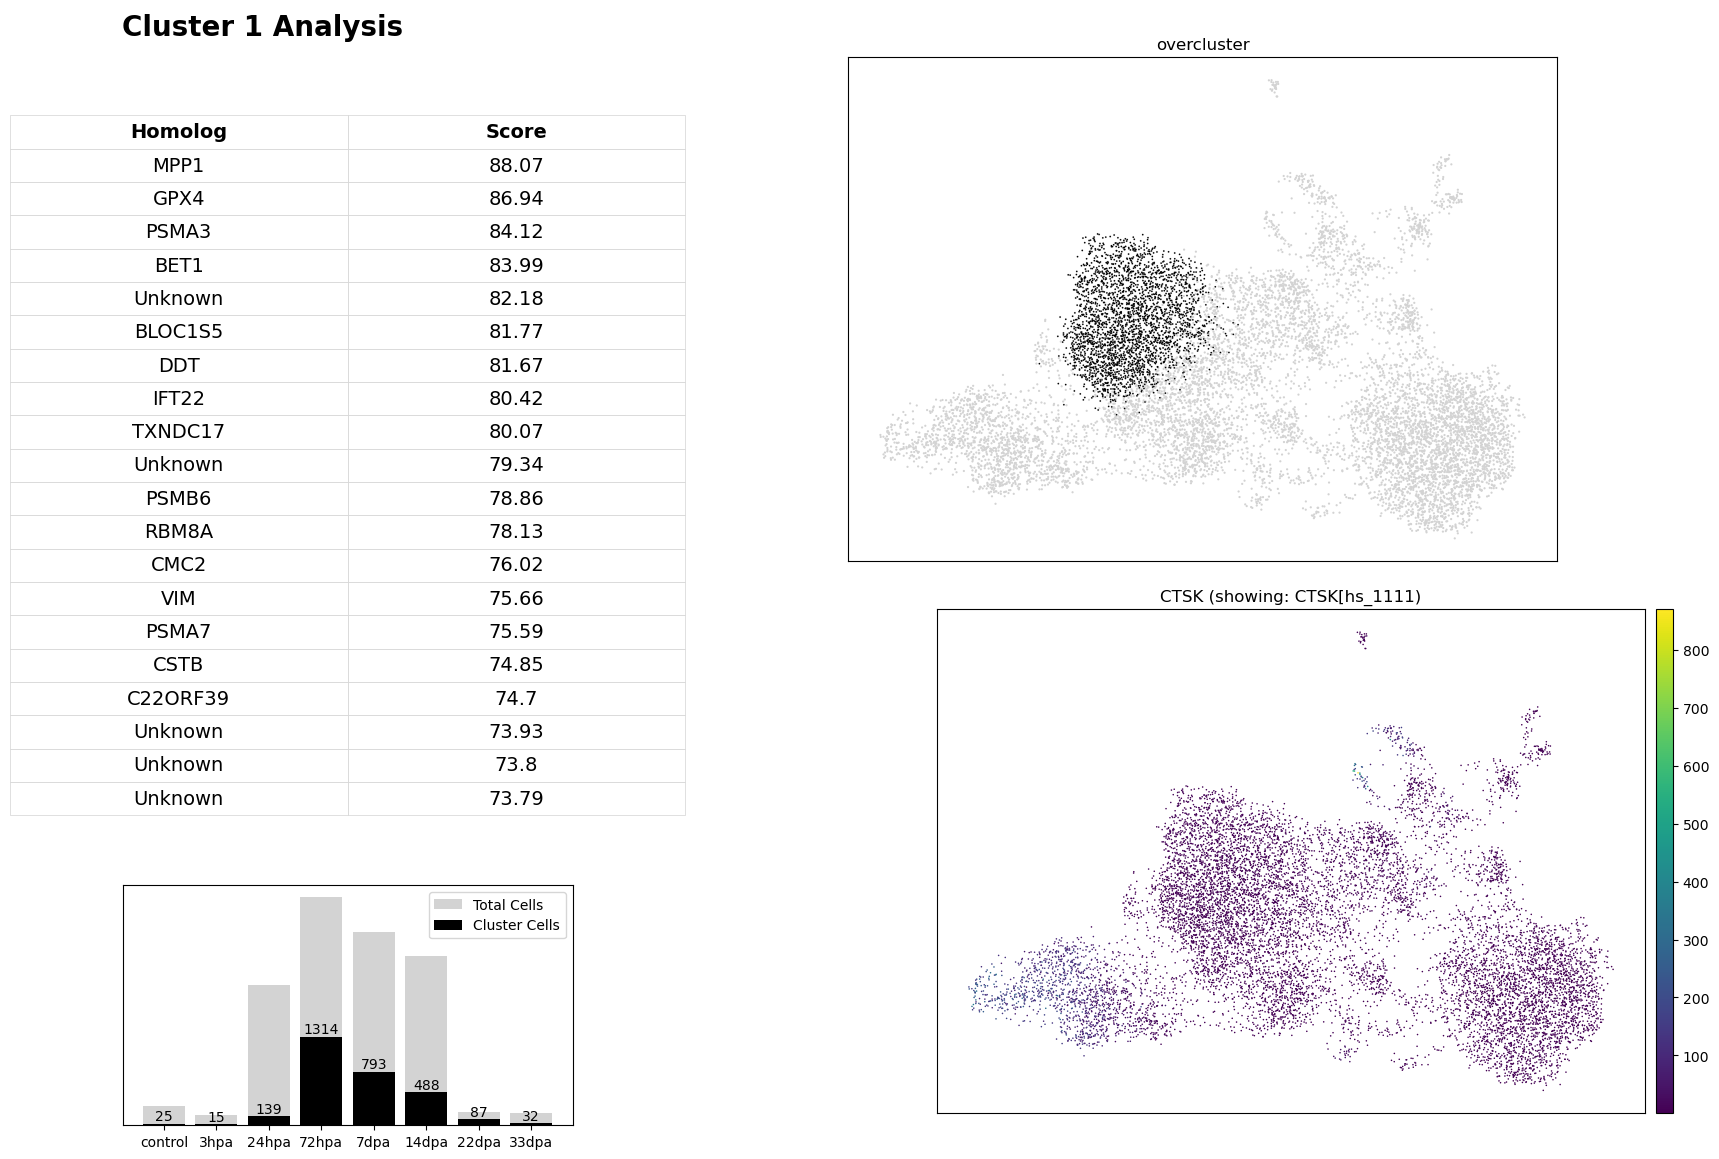

In [42]:
analyze_cluster(adata, cluster='1', gene_name="CTSK")

In [11]:
sc.tl.rank_genes_groups(adata, groupby='overcluster', groups='all', reference='rest', layer = 'scVI_normalized')
adata

AnnData object with n_obs × n_vars = 64380 × 11485
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [17]:
import pandas as pd

all_results = []
for i in range(62):
    df = sc.get.rank_genes_groups_df(adata, group=str(i)).head(20)
    # Remove underscore and everything after in the 'names' column
    df["names"] = df["names"].str.replace(r'_.*', '', regex=True)
    df["cluster"] = i
    all_results.append(df)

final_df = pd.concat(all_results)
final_df.to_csv("../results/differential_gene_expression_by_cluster.csv", index=False)

In [539]:
cluster_annotation = {
    '21' : 'Perycytes',
    '21' : 'Myocytes',
    '20' : 'Metabolically Active',
    '19' : 'Differentiating',
    '18' : 'Differentiating',
    '17' : 'Tissue-Invading Monocytes',
    '16' : 'Inflammation Response Fibroblasts',
    '15' : 'Mature Chondrocytes',
    '14' : 'Hypoxia Adapted Proliferating Cells',
    '13' : 'Oxidative Stress Response Cells',
    '12' : 'Regulatory Mesenchymal Cells',
    '11' : 'Osteoblasts',
    '10': 'Wound Healing Fibroblasts',
    '9' : 'ECM-Producing Fibroblasts',
    '8' : 'Immune Modulating Fibroblasts',
    '7' : 'High Protein Synthesis Fibroblasts',
    '6' : 'Immune Modulating Fibroblasts',
    '5' : 'Proliferating Fibroblasts',
    '4' : 'Proliferative Mesenchymal Cells',
    '3' : 'Skeletal/Muscle Precursor Cells',
    '2' : 'Cartilage Precursors',
    '1' : 'Muscle-Associated Precursors',
    '0' : 'Proliferating Progenitor Cells',
}

In [540]:
# Function to map cluster number to cell type
def map_cluster_to_cell_type(cluster):
    return cluster_annotation.get(str(cluster), "Unknown")

# Assuming 'overcluster' is the column in adata.obs containing the cluster assignments
adata.obs['overcluster_cell_type'] = adata.obs['overcluster'].map(map_cluster_to_cell_type)

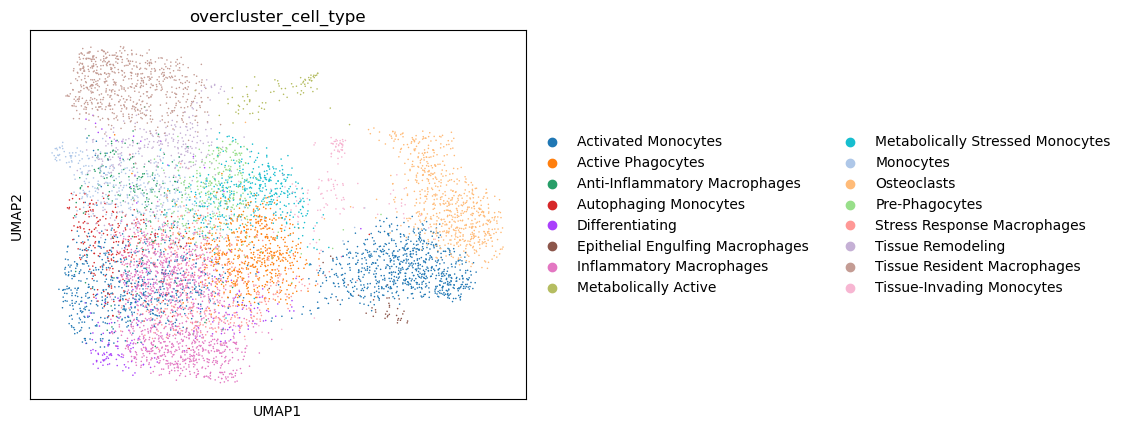

In [541]:
sc.pl.umap(adata, color='overcluster_cell_type', s=5, components='all')

In [338]:
adata

AnnData object with n_obs × n_vars = 11646 × 10035
    obs: 'Timepoint', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_g1_phase', 'log1p_total_counts_g1_phase', 'pct_counts_g1_phase', 'total_counts_s_phase', 'log1p_total_counts_s_phase', 'pct_counts_s_phase', 'total_counts_g2_phase', 'log1p_total_counts_g2_phase', 'pct_counts_g2_phase', 'total_counts_m_phase', 'log1p_total_counts_m_phase', 'pct_counts_m_phase', 'total_counts_g0_phase', 'log1p_total_counts_g0_phase', 'pct_counts_g0_phase', 'total_counts_proliferation', 'log1p_total_counts_proliferation', 'pct_counts_proliferation', 'total_counts_apoptosis_pro', 'log1p_total_counts_apoptosis_pro', 'pct_counts_apoptosis_pro', 'total_counts_apoptosis_anti', 'lo

In [135]:
import scvi

In [34]:
from scvi.autotune import ModelTuner
from ray import tune

In [36]:
mod = scvi.model.SCVI
mod.setup_anndata(adata, categorical_covariate_keys = ['Timepoint'],
                       continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo', 'log1p_total_counts_s_phase', 
                                                  'log1p_total_counts_g2_phase', 'log1p_total_counts_m_phase', 
                                                  'log1p_total_counts_proliferation', 'log1p_total_counts_apoptosis_pro',
                                                 'log1p_total_counts_apoptosis_anti'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [339]:
model = scvi.model.SCVI.load('immune_model/', adata)

INFO     File immune_model/model.pt already downloaded                                                             


In [340]:
vae = scvi.model.SCVI.load('immune_model/', adata)

INFO     File immune_model/model.pt already downloaded                                                             


In [341]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, unlabeled_category = 'Unresolved', 
                                        labels_key = 'overcluster_cell_type')
lvae.train(max_epochs = 50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [02:40<00:00,  3.18s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.4e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [02:40<00:00,  3.20s/it, v_num=1, train_loss_step=1.43e+3, train_loss_epoch=1.4e+3]


In [342]:
adata.obs['pred_celltype'] = lvae.predict(adata)

In [28]:
adata.obs['pred_celltype'] = adata.obs['pred_celltype'].replace('Chrondrocytes', 'Chondrocytes')

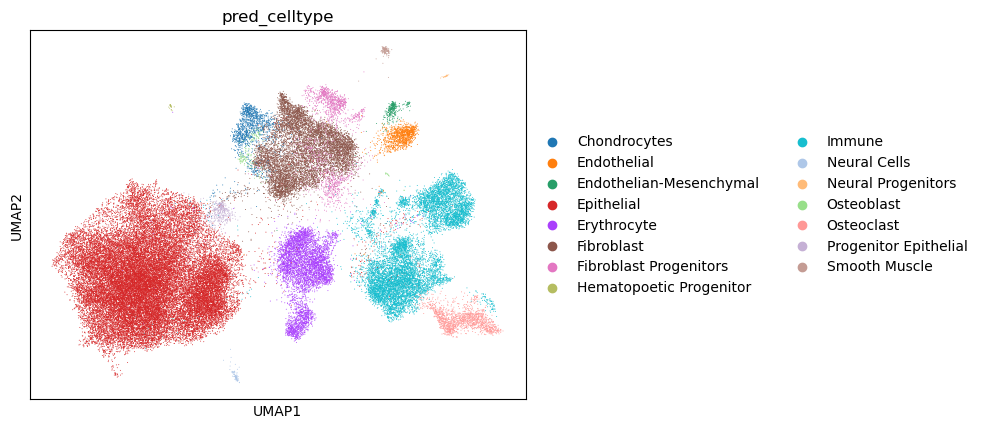

In [27]:
sc.pl.umap(adata, color = 'pred_celltype')

In [542]:
umap_coords = adata.obsm['X_umap']
# Extract cell IDs (from .obs_names or index)
cell_ids = adata.obs_names

# Extract the timepoint information (assuming it's stored in `adata.obs['timepoint']`)
labels = adata.obs['overcluster_cell_type']

# Create a DataFrame with cell IDs, timepoints, and UMAP coordinates
umap_df = pd.DataFrame({
    'Cell': cell_ids,
    'Cell Type': labels,
    'UMAP1': umap_coords[:, 0],  # First UMAP dimension
    'UMAP2': umap_coords[:, 1]   # Second UMAP dimension
})

# Save it as a CSV file
umap_df.to_csv('../results/annotations/level_3/monocyte_labeled_umap.csv', index=False)

In [543]:
adata.write_h5ad('../results/annotations/level_3/annotated_monocyte_adata.h5ad')

In [345]:
# Groupings based on your mappings
group_mappings = {
    'Monocytes': ['Macrophages', 'Osteoclasts', 'Myeloid Derived Suppressor Cells'],
    'Granulocytes' : ['Granulocytes', 'Myeloid Derived Suppressor Cells'],
    'T-Cells' : ['T-Cells']
}

# Iterate over each group and create/save subset AnnData objects
for group_name, cell_types in group_mappings.items():
    # Filter the adata based on cell types in the group
    subset_adata = adata[adata.obs['pred_celltype'].isin(cell_types)].copy()
    
    # Save the subset AnnData object
    subset_adata.write(f"../results/annotations/level_2/{group_name}_adata.h5ad")
    
    # Extract UMAP coordinates and cell type labels
    umap_coords = subset_adata.obsm['X_umap']
    cell_ids = subset_adata.obs_names
    labels = subset_adata.obs['pred_celltype']
    
    # Create DataFrame with UMAP coordinates
    umap_df = pd.DataFrame({
        'Cell': cell_ids,
        'Cell Type': labels,
        'UMAP1': umap_coords[:, 0],
        'UMAP2': umap_coords[:, 1]
    })
    
    # Save UMAP DataFrame as CSV
    umap_df.to_csv(f"../results/annotations/level_2/{group_name}_labeled_umap.csv", index=False)

    print(f"Saved {group_name} subset and UMAP CSV.")

Saved Monocytes subset and UMAP CSV.
Saved Granulocytes subset and UMAP CSV.
Saved T-Cells subset and UMAP CSV.


MovieWriter ffmpeg unavailable; using Pillow instead.


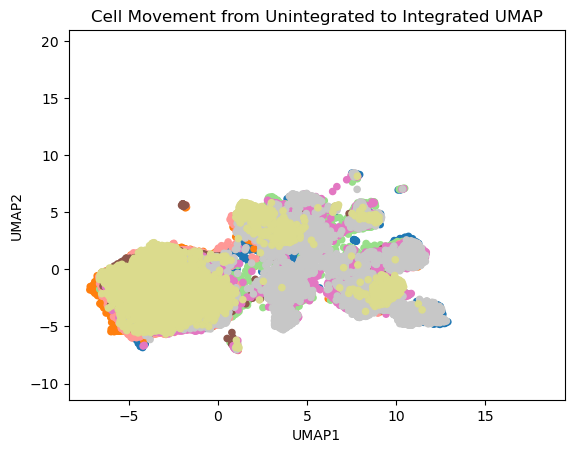

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load the CSVs
unintegrated = pd.read_csv('unintegrated_umap.csv')
integrated = pd.read_csv('integrated_umap.csv')

# Merge data on the 'Cell' column
merged_data = pd.merge(unintegrated, integrated, on='Cell', suffixes=('_unint', '_int'))

# Unique timepoints and color mapping
timepoints = merged_data['Timepoint_unint'].unique()
color_map = {timepoint: plt.cm.tab20(i / len(timepoints)) for i, timepoint in enumerate(timepoints)}

# Initialize the plot
fig, ax = plt.subplots()
scat = ax.scatter(merged_data['UMAP1_unint'], merged_data['UMAP2_unint'], 
                  c=[color_map[tp] for tp in merged_data['Timepoint_unint']], s=20)

# Set axis limits
ax.set_xlim(merged_data[['UMAP1_unint', 'UMAP1_int']].min().min() - 1, 
            merged_data[['UMAP1_unint', 'UMAP1_int']].max().max() + 1)
ax.set_ylim(merged_data[['UMAP2_unint', 'UMAP2_int']].min().min() - 1, 
            merged_data[['UMAP2_unint', 'UMAP2_int']].max().max() + 1)

# Add labels and title
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Cell Movement from Unintegrated to Integrated UMAP')

def update(frame):
    # Calculate interpolated positions for each frame
    merged_data['UMAP1_interp'] = merged_data['UMAP1_unint'] + (merged_data['UMAP1_int'] - merged_data['UMAP1_unint']) * frame / 100
    merged_data['UMAP2_interp'] = merged_data['UMAP2_unint'] + (merged_data['UMAP2_int'] - merged_data['UMAP2_unint']) * frame / 100
    
    # Update scatter plot data
    scat.set_offsets(merged_data[['UMAP1_interp', 'UMAP2_interp']].values)
    
    return scat,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=100, interval=50, blit=True)

# Save or display the animation
ani.save('umap_animation.gif', fps=30, dpi=150)
plt.show()  # Uncomment to display the animation
